# **An Investigation of Love Live! School Idol Festival All Stars Card Data**
---

## **Introduction:**

![:YouWave: from the School Idol Festival Discord server](https://cdn.discordapp.com/emojis/993209197565071452.png)

### **Game History and Fundamentals:**

First announced in 2017, Love Live! School Idol Festival All Stars, or SIFAS for short, is a game originally developed by KLab Inc. and published by Bushiroad. It was released in Japan on Septempber 26, 2019, 'Worldwide' on Feburary 25, 2020, and in Mainland China on May 28, 2021. On April 30, 2023 it was announced that the game would be ending its service on June 30, 2023. (This announcement was made approximately one week prior to the time of writing this.)

The gameplay of SIFAS consists of a mixture of RPG and rhythm game elements, wherein songs act as dungeons in some sense, and you create team formations intended to clear the dungeons. These formations consist of 9 'cards', arranged into 3 'subunits' or 'strategies' of 3 cards each. 

During songs, the 3 cards in the active strategy cycle through tapping notes in a round robin fashion. The value of score gained is determined per note by the card that 'tapped' that note. This is the primary function of a card's appeal stat. Unlike many rhythm games, all notes have a base value of damage they inflict, regardless of whether or not the note was tapped or missed. This is where the stamina value of cards come into play, as having a team formation with a higher total stamina value will make it easier to survive songs with high note damage. The third primary stat card have is their technique, which is used in several different calculations, but namely for our purposes, the critical rate of a card.

### **Purpose of This Notebook:**

This notebook exists to attempt to analyze some of the card data from the game. This inclues spotting trends in stats over time, tendencies for certain card types to have certain stat distributions, tendencies for attributes to have certain stat distributions, etc. As of the time of writing this, there are 898 cards in the game. With the End of Service announcement there's likely to be just over 900 cards at the end of the game. (Well, at least I can say I have a representative sample size... haha... right...?)

The data is created and owned by [KLab Games](https://www.klab.com/en/klabgames/)/[MyNet Games](https://www.mynet.co.jp) (website is in Japanese) and [Sunrise](https://www.sunrise-inc.co.jp/international/)/[Bushiroad](https://en.bushiroad.com), and was collected by [Kirara Research](https://github.com/kirara-research). The API to the [Kirara](https://allstars.kirara.ca) backend is provided by [summertriangle-dev](https://github.com/summertriangle-dev) and is explained [here](https://github.com/summertriangle-dev/arposandra/wiki/API-(Cards)).

As it is currently unknown how long Kirara will continue to be hosted due to the end of the game's service, a serialized json file containing the data and the card ID list, and relevant API responses will be created and bundled with this notebook so it will work properly.

### **Copyright Information:**
To the best of my understanding, this project falls under the [fair use category of copyright](https://www.copyright.gov/fair-use/more-info.html) as this project is 1) for noncommercial educational purposes, 2) is transformative as it adds analysis of the data that can not be done natively within the game and does not act a subsitute for the original work, 3) only uses a small section of the overall game's data, 4) is ***very*** unlikely to cause harm to the future market of the game and/or Bushiroad's future use of the Love Live! IP. These factors are only amplified by the End of Service announcement made on April 30, 2023. All character IP's, songs, assets, etc are owned by their respective owners (Bushiroad, Sunrise, etc) and I claim no ownership of such.

---

## **Reading in the Data:**

In [1]:
# Import necessary packages
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### **Gathering the Data:**

Before we can analyze any of the data, we're going to have to gather it. The following code grabs the card id_list.json and uses it to create a list of URLs which we'll querry for each individual card's data. 

In [2]:
# This provideds data to convert between ids and ordinals (object ids, and card numbers)
# if they are not directly known, and is used for figuring out how many cards there are.

# Request the id_list json.
id_list = requests.get("https://allstars.kirara.ca/api/private/cards/id_list.json")

#id_list.text
id_list.json()

{'result': [{'ordinal': 1, 'id': 100011001},
  {'ordinal': 2, 'id': 100011002},
  {'ordinal': 3, 'id': 100012001},
  {'ordinal': 4, 'id': 100013001},
  {'ordinal': 5, 'id': 100021001},
  {'ordinal': 6, 'id': 100021002},
  {'ordinal': 7, 'id': 100022001},
  {'ordinal': 8, 'id': 100023001},
  {'ordinal': 9, 'id': 100031001},
  {'ordinal': 10, 'id': 100031002},
  {'ordinal': 11, 'id': 100032001},
  {'ordinal': 12, 'id': 100033001},
  {'ordinal': 13, 'id': 100041001},
  {'ordinal': 14, 'id': 100041002},
  {'ordinal': 15, 'id': 100042001},
  {'ordinal': 16, 'id': 100043001},
  {'ordinal': 17, 'id': 100051001},
  {'ordinal': 18, 'id': 100051002},
  {'ordinal': 19, 'id': 100052001},
  {'ordinal': 20, 'id': 100053001},
  {'ordinal': 21, 'id': 100061001},
  {'ordinal': 22, 'id': 100061002},
  {'ordinal': 23, 'id': 100062001},
  {'ordinal': 24, 'id': 100063001},
  {'ordinal': 25, 'id': 100071001},
  {'ordinal': 26, 'id': 100071002},
  {'ordinal': 27, 'id': 100072001},
  {'ordinal': 28, 'id': 100

In [3]:
# This cell creates a list of the URLs to request the jsons from.

# I believe this can also be done by passing in a comma separated list
# in to the URL instead of one number, but this was less work to code
# and I don't know if there would be any issues requesting a URL with 
# that many characters/recieving a request that large.

final_card_number = id_list.json()["result"][-1]["ordinal"] 

# Thanks to KGB33 for condensing my code with the f-strings and list comprehension
URL_list = [f"https://allstars.kirara.ca/api/private/cards/ordinal/{card_number}.json"
            for card_number in range(1, final_card_number + 1)]

URL_list

['https://allstars.kirara.ca/api/private/cards/ordinal/1.json',
 'https://allstars.kirara.ca/api/private/cards/ordinal/2.json',
 'https://allstars.kirara.ca/api/private/cards/ordinal/3.json',
 'https://allstars.kirara.ca/api/private/cards/ordinal/4.json',
 'https://allstars.kirara.ca/api/private/cards/ordinal/5.json',
 'https://allstars.kirara.ca/api/private/cards/ordinal/6.json',
 'https://allstars.kirara.ca/api/private/cards/ordinal/7.json',
 'https://allstars.kirara.ca/api/private/cards/ordinal/8.json',
 'https://allstars.kirara.ca/api/private/cards/ordinal/9.json',
 'https://allstars.kirara.ca/api/private/cards/ordinal/10.json',
 'https://allstars.kirara.ca/api/private/cards/ordinal/11.json',
 'https://allstars.kirara.ca/api/private/cards/ordinal/12.json',
 'https://allstars.kirara.ca/api/private/cards/ordinal/13.json',
 'https://allstars.kirara.ca/api/private/cards/ordinal/14.json',
 'https://allstars.kirara.ca/api/private/cards/ordinal/15.json',
 'https://allstars.kirara.ca/api/p

In [4]:
# THIS IS THE ACTUAL WEB REQUEST FOR ALL CARDS
# DON'T RUN UNLESS NECESSARY IT'S SLOW

request_result_list = [requests.get(URL) for URL in URL_list]

In [5]:
# Example of structure of returned json.
request_result_list[0].json()

{'result': [{'id': 100011001,
   'ordinal': 1,
   'rarity': 10,
   'max_level': 40,
   'attribute': 1,
   'role': 1,
   'training_tree_m_id': 100011001,
   'sp_point': 1,
   'exchange_item_id': 1,
   'max_passive_skill_slot': 2,
   'base_critical_rate': 0.3,
   'critical_rate_additive_bonus': 1500,
   'background_asset_path': 'eS',
   'member': 1,
   'role_effect': {'change_effect_type': 1,
    'change_effect_value': 500,
    'positive_type': 1,
    'positive_value': 500,
    'negative_type': 3,
    'negative_value': 500},
   'normal_appearance': {'name': 'Otonokizaka High Second-Year',
    'image_asset_path': 'https://tirofinale.kirara.ca/i/-SFc/68pelRbkP12syA.png',
    'thumbnail_asset_path': 'https://tirofinale.kirara.ca/s/ci/svm/-cEY/HkHXk-xS-ew5rA.png'},
   'idolized_appearance': {'name': "Energetic Girl Who's All Smiles",
    'image_asset_path': 'https://tirofinale.kirara.ca/i/-KCo/z32PcutQhMjutQ.png',
    'thumbnail_asset_path': 'https://tirofinale.kirara.ca/s/ci/svm/-dFg/XTZMQn

### **Creating a serialized file with the data:**

The following code blocks save the id_list and request results as serialized .json files. This is partly because I wanted the data in a more permanent format - as was explained in the [Purpose of This Notebook](#Purpose-of-This-Notebook:), and partly to reduce the number of requests made to the Kirara API.

In [6]:
# Save id_list in a serialized format

with open("sifas_data_id_list.json", "w") as f:
    json.dump(id_list.json(), f)

In [7]:
# Save request jsons in a serialized format

# Collect only the results of the requests to be saved in a list
request_result_list_jsons = [request.json()["result"][0] for request in request_result_list]

with open("sifas_data.json", "w") as f:
    json.dump(request_result_list_jsons, f)

### **Reading the data from a serialized file:**

The following code blocks serve as examples to read and bring in data from the serialized file in case the pandas read_json() function fails to.

In [8]:
# Read serialized id_list
# This is read in a dict

with open("sifas_data_id_list.json", "r") as f:
    sifas_data_id_list = json.load(f)

In [9]:
# Read serialized sifas_data
# This is read in as a list

with open("sifas_data.json", "r") as f:
    sifas_data = json.load(f)

In [10]:
# Example of item in list
sifas_data[0]

{'id': 100011001,
 'ordinal': 1,
 'rarity': 10,
 'max_level': 40,
 'attribute': 1,
 'role': 1,
 'training_tree_m_id': 100011001,
 'sp_point': 1,
 'exchange_item_id': 1,
 'max_passive_skill_slot': 2,
 'base_critical_rate': 0.3,
 'critical_rate_additive_bonus': 1500,
 'background_asset_path': 'eS',
 'member': 1,
 'role_effect': {'change_effect_type': 1,
  'change_effect_value': 500,
  'positive_type': 1,
  'positive_value': 500,
  'negative_type': 3,
  'negative_value': 500},
 'normal_appearance': {'name': 'Otonokizaka High Second-Year',
  'image_asset_path': 'https://tirofinale.kirara.ca/i/-SFc/68pelRbkP12syA.png',
  'thumbnail_asset_path': 'https://tirofinale.kirara.ca/s/ci/svm/-cEY/HkHXk-xS-ew5rA.png'},
 'idolized_appearance': {'name': "Energetic Girl Who's All Smiles",
  'image_asset_path': 'https://tirofinale.kirara.ca/i/-KCo/z32PcutQhMjutQ.png',
  'thumbnail_asset_path': 'https://tirofinale.kirara.ca/s/ci/svm/-dFg/XTZMQnnyWJHYvQ.png'},
 'active_skill': {'id': 10000101,
  'name': 'H

### **Storing the data in a DataFrame:**

The following few pieces of code are commented out and will not run by default. They are a remnant from before I was creating the serialized file, as pd.read_json(obj) and pd.DataFrame(request_result_list) had issues reading the data (byte strings or something).

This notebook currently (May 07, 2023 at the time of writing) does not depend on them.

In [11]:
# From _Alt_Old notebook

# #Building the dataframe by "mining" the json.

# ids = []
# max_level = [] 
# role = []
# re_CEV = []


# df1 = pd.DataFrame()
# for request in request_result_list:
#     ids.append(request.json()["result"][0]["id"])
#     max_level.append(request.json()["result"][0]["max_level"])
#     role.append(request.json()["result"][0]["role"])
#     re_CEV.append(request.json()["result"][0]["role_effect"]["change_effect_value"])
    
# TheData = pd.DataFrame()

# TheData["ids"] = ids
# TheData["max_level"] = max_level
# TheData["role"] = role
# TheData["RE_CEV"] = re_CEV

# TheData

In [12]:
# #Build the dataframe from the json

# RawCardData = pd.DataFrame()

# RawCardData["ordinal"] = [card_data["ordinal"]
#                           for card_data in sifas_data]
# RawCardData["rarity"] = [card_data["rarity"]
#                          for card_data in sifas_data]
# RawCardData["max_level"] = [card_data["max_level"]
#                             for card_data in sifas_data]
# RawCardData["attribute"] = [card_data["attribute"]
#                             for card_data in sifas_data]
# RawCardData["role"] = [card_data["role"]
#                        for card_data in sifas_data]
# #RawCardData["sp_point"] = [card_data["sp_point"]
# #                           for card_data in sifas_data]
# RawCardData["max_passive_skill_slot"] = [card_data["max_passive_skill_slot"]
#                                          for card_data in sifas_data]
# RawCardData["base_critical_rate"] = [card_data["base_critical_rate"]
#                                      for card_data in sifas_data]
# RawCardData["critical_rate_additive_bonus"] = [card_data["critical_rate_additive_bonus"]
#                                                for card_data in sifas_data]
# RawCardData["member"] = [card_data["member"]
#                          for card_data in sifas_data]
# RawCardData["idolized_offset"] = [card_data["idolized_offset"]
#                                   for card_data in sifas_data]
# RawCardData["tt_offset"] = [card_data["tt_offset"]
#                             for card_data in sifas_data]
# RawCardData["stats"] = [card_data["stats"]
#                         for card_data in sifas_data]
# RawCardData["source"]  = [card_data["source"]
#                           for card_data in sifas_data]
# #RawCardData["RE_CEV"] = [card_data["role_effect"]["change_effect_value"]
# #                         for card_data in sifas_data]

In [13]:
# #Build the dataframe by "mining" the json

# ordinal = []
# rarity = []
# max_level = []
# attribute = []
# role = []
# #sp_point = []
# max_passive_skill_slot = []
# base_critical_rate = []
# critical_rate_additive_bonus = []
# member = []
# idolized_offset = []
# tt_offset = []
# stats = []
# source = []
# #re_CEV = []

# for card_data in sifas_data:
#     ordinal.append(card_data["ordinal"])
#     rarity.append(card_data["rarity"])
#     max_level.append(card_data["max_level"])
#     attribute.append(card_data["attribute"])
#     role.append(card_data["role"])
#     #sp_point.append(card_data["sp_point"])
#     max_passive_skill_slot.append(card_data["max_passive_skill_slot"])
#     base_critical_rate.append(card_data["base_critical_rate"])
#     critical_rate_additive_bonus.append(card_data["critical_rate_additive_bonus"])
#     member.append(card_data["member"])
#     idolized_offset.append(card_data["idolized_offset"])
#     tt_offset.append(card_data["tt_offset"])
#     stats.append(card_data["stats"])
#     source.append(card_data["source"])
#     #re_CEV.append(card_data["role_effect"]["change_effect_value"])
    
# RawCardData = pd.DataFrame()

# RawCardData["ordinal"] = ordinal
# RawCardData["rarity"] = rarity
# RawCardData["max_level"] = max_level
# RawCardData["attribute"] = attribute
# RawCardData["role"] = role
# #RawCardData["sp_point"] = sp_point
# RawCardData["max_passive_skill_slot"] = max_passive_skill_slot
# RawCardData["base_critical_rate"] = base_critical_rate
# RawCardData["critical_rate_additive_bonus"] = critical_rate_additive_bonus
# RawCardData["member"] = member
# RawCardData["idolized_offset"] = idolized_offset
# RawCardData["tt_offset"] = tt_offset
# RawCardData["stats"] = stats
# RawCardData["source"] = source
# #RawCardData["RE_CEV"] = re_CEV

In [14]:
# Create the DataFrame and preview it to check 
# that all the initial data got imported properly
RawCardData = pd.read_json("sifas_data.json")
RawCardData

,id,ordinal,rarity,max_level,attribute,role,training_tree_m_id,sp_point,exchange_item_id,max_passive_skill_slot,...,normal_appearance,idolized_appearance,active_skill,passive_skills,idolized_offset,tt_offset,stats,costume_info,source,release_dates
0,100011001,1,10,40,1,1,100011001,1,1,2,...,"{'name': 'Otonokizaka High Second-Year', 'imag...","{'name': 'Energetic Girl Who's All Smiles', 'i...","{'id': 10000101, 'name': 'Hang in There!', 'de...","[{'id': 20000101, 'name': 'Technique+ :Same At...","[1, 62, 51, 93]","[[0, 928, 776, 1392], [1, 1083, 1034, 1624], [...","[[1, 621, 517, 931], [2, 629, 524, 943], [3, 6...",None,1,"{'en': '2020-02-24T15:00:00+00:00', 'jp': '201..."
1,100011002,2,10,40,4,2,100011002,1,1,2,...,"{'name': 'Leader of μ's', 'image_asset_path': ...","{'name': 'Challenge Seeker', 'image_asset_path...","{'id': 10000201, 'name': 'School Idol Revoluti...","[{'id': 20000201, 'name': 'Technique+ :Same Sc...","[1, 71, 82, 82]","[[0, 1064, 1240, 1240], [1, 1418, 1447, 1447],...","[[1, 711, 829, 829], [2, 721, 840, 840], [3, 7...",None,1,"{'en': '2020-02-24T15:00:00+00:00', 'jp': '201..."
2,100012001,3,20,60,2,4,100012001,2,2,3,...,"{'name': 'Bread Shared with Kotori', 'image_as...","{'name': 'Fresh Fruits Parlor', 'image_asset_p...","{'id': 10000301, 'name': 'Achieving One's Drea...","[{'id': 20000401, 'name': 'Technique+ :Same At...","[1, 128, 96, 96]","[[0, 1920, 1440, 1440], [1, 2432, 1824, 1824],...","[[1, 1280, 960, 960], [2, 1291, 969, 969], [3,...","[WU, 100012001, None, None]",1,"{'en': '2020-02-24T15:00:00+00:00', 'jp': '201..."
3,100013001,4,30,80,6,3,100013001,3,3,3,...,"{'name': 'Battle in the Big Zoo!', 'image_asse...","{'name': 'Fashionable Romance', 'image_asset_p...","{'id': 10000401, 'name': 'Romantic Taisho Roma...","[{'id': 20000601, 'name': 'Stamina+ :Group', '...","[1, 156, 234, 130]","[[0, 2340, 3504, 1944], [1, 3216, 4380, 2187],...","[[1, 1170, 1755, 975], [2, 1180, 1770, 984], [...","[91, 100013001, None, None]",1,"{'en': '2020-02-24T15:00:00+00:00', 'jp': '201..."
4,100021001,5,10,40,3,2,100021001,1,1,2,...,"{'name': 'Otonokizaka High Third-Year', 'image...",{'name': 'Intelligent and Beautiful President'...,"{'id': 10000501, 'name': 'Harasho', 'descripti...","[{'id': 20000701, 'name': 'Stamina+ :Same Stra...","[1, 68, 68, 70]","[[0, 1024, 1024, 1048], [1, 1364, 1194, 1223],...","[[1, 683, 683, 703], [2, 692, 692, 713], [3, 7...",None,1,"{'en': '2020-02-24T15:00:00+00:00', 'jp': '201..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,402072008,902,20,60,3,2,402072008,2,2,3,...,"{'name': 'Peridot Power Charge!', 'image_asset...","{'name': 'Miracle STAY TUNE!', 'image_asset_pa...","{'id': 10089901, 'name': 'Dream Come True', 'd...","[{'id': 20173101, 'name': 'Technique+ :Same At...","[1, 162, 98, 166]","[[0, 2270, 1370, 2330], [1, 2952, 1782, 3030],...","[[1, 1626, 984, 1669], [2, 1640, 993, 1684], [...","[Ox-, 402072008, None, None]",3,"{'en': '2023-05-19T06:00:00+00:00', 'jp': '202..."
902,402053010,903,30,80,4,4,402053010,3,3,3,...,"{'name': 'It's Kind of Embarrassing...', 'imag...","{'name': 'Mysterious Jewelry', 'image_asset_pa...","{'id': 10090001, 'name': 'Catch My Good Side!'...","[{'id': 20173301, 'name': 'Appeal and Techniqu...","[1, 273, 140, 287]","[[0, 4092, 2100, 4296], [1, 4603, 2624, 5910],...","[[1, 2047, 1050, 2152], [2, 2065, 1059, 2171],...","[U>g, 402053010, None, None]",3,"{'en': '2023-05-19T06:00:00+00:00', 'jp': '202..."
903,402103005,904,30,80,6,3,402103005,3,3,3,...,"{'name': 'I Tried to Come Up With a Pose...', ...","{'name': 'Mysterious Jewelry', 'image_asset_pa...","{'id': 10090101, 'name': 'Keep a Look Out For ...","[{'id': 20173501, 'name': 'Stamina+ :Same Attr...","[1, 141, 271, 177]","[[0, 2124, 4068, 2652], [1, 2919, 5084, 2983],...","[[1, 1062, 2035, 1327], [2, 1071, 2053, 1339],...","[xW\, 402103005, None, None]",2,"{'en': '2023-05-22T06:00:00+00:00', 'jp': '202..."
904,401062007,905,20,60,5,4,401062007,2,2,3,...,"{

In [15]:
RawCardData.keys()

Index(['id', 'ordinal', 'rarity', 'max_level', 'attribute', 'role',
       'training_tree_m_id', 'sp_point', 'exchange_item_id',
       'max_passive_skill_slot', 'base_critical_rate',
       'critical_rate_additive_bonus', 'background_asset_path', 'member',
       'role_effect', 'normal_appearance', 'idolized_appearance',
       'active_skill', 'passive_skills', 'idolized_offset', 'tt_offset',
       'stats', 'costume_info', 'source', 'release_dates'],
      dtype='object')

### **Adding some calculated values to the DataFrame:**

While we have all the base data in a dataframe now, we're going to pull out some stats and add some calculated ones; for ease of access and further investigation respectively.

In [16]:
# Theoretically a lot of the code in this section 
# should be condensable, but I was having issues
# with items access

In [17]:
# Create columns which hold the stats a card will have at max level.

max_level_appeal = []
max_level_stamina = []
max_level_technique = []

i = RawCardData.index.start
while i < RawCardData.index.stop:
    max_level_appeal.append(RawCardData["stats"].array[i][RawCardData["max_level"].array[i] - 1][1])
    max_level_stamina.append(RawCardData["stats"].array[i][RawCardData["max_level"].array[i] - 1][2])
    max_level_technique.append(RawCardData["stats"].array[i][RawCardData["max_level"].array[i] - 1][3])
    i += 1

RawCardData["max_level_appeal"] = max_level_appeal
RawCardData["max_level_stamina"] = max_level_stamina
RawCardData["max_level_technique"] = max_level_technique

In [18]:
# Create columns which hold the stats a card will have with a fully complete training tree.

max_tt_appeal = []
max_tt_stamina = []
max_tt_technique = []

i = RawCardData.index.start
while i < RawCardData.index.stop:
    max_tt_appeal.append(RawCardData["tt_offset"][i][5][1])
    max_tt_stamina.append(RawCardData["tt_offset"][i][5][2])
    max_tt_technique.append(RawCardData["tt_offset"][i][5][3])
    i += 1

RawCardData["max_tt_appeal"] = max_tt_appeal
RawCardData["max_tt_stamina"] = max_tt_stamina
RawCardData["max_tt_technique"] = max_tt_technique

In [19]:
# Create columns which hold the total max stats a card will have.
# This is a sum of the stats from max level, a fully complete training tree
# and the 1 node in the training tree that idolizes/transforms the card.

total_max_appeal = []
total_max_stamina = []
total_max_technique = []

i = RawCardData.index.start
while i < RawCardData.index.stop:
    total_max_appeal.append(RawCardData["idolized_offset"][i][1]
                            + RawCardData["max_level_appeal"][i]
                            + RawCardData["max_tt_appeal"][i])
    total_max_stamina.append(RawCardData["idolized_offset"][i][2]
                             + RawCardData["max_level_stamina"][i]
                             + RawCardData["max_tt_stamina"][i])
    total_max_technique.append(RawCardData["idolized_offset"][i][3]
                               + RawCardData["max_level_technique"][i]
                               + RawCardData["max_tt_technique"][i])
    i += 1
    
RawCardData["total_max_appeal"] = total_max_appeal
RawCardData["total_max_stamina"] = total_max_stamina
RawCardData["total_max_technique"] = total_max_technique

In [20]:
# Create a column which holds the critical rate of a fully maxed out card.

max_critical_rate = []

i = RawCardData.index.start
while i < RawCardData.index.stop:
    max_critical_rate.append((RawCardData["base_critical_rate"][i]
                             * RawCardData["total_max_technique"][i]
                             + RawCardData["critical_rate_additive_bonus"][i])
                             / 10000)

    i += 1
    
RawCardData["max_critical_rate"] = max_critical_rate

# Critical rate is bounded between 0 and 1

In [21]:
RawCardData

,id,ordinal,rarity,max_level,attribute,role,training_tree_m_id,sp_point,exchange_item_id,max_passive_skill_slot,...,max_level_appeal,max_level_stamina,max_level_technique,max_tt_appeal,max_tt_stamina,max_tt_technique,total_max_appeal,total_max_stamina,total_max_technique,max_critical_rate
0,100011001,1,10,40,1,1,100011001,1,1,2,...,931,776,1397,2173,1811,3260,3166,2638,4750,0.29250
1,100011002,2,10,40,4,2,100011002,1,1,2,...,1066,1244,1244,2488,2903,2903,3625,4229,4229,0.12687
2,100012001,3,20,60,2,4,100012001,2,2,3,...,1920,1440,1440,4480,3360,3360,6528,4896,4896,0.14688
3,100013001,4,30,80,6,3,100013001,3,3,3,...,1950,2925,1625,5850,8775,4875,7956,11934,6630,0.19890
4,100021001,5,10,40,3,2,100021001,1,1,2,...,1024,1024,1055,2390,2390,2462,3482,3482,3587,0.25761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,402072008,902,20,60,3,2,402072008,2,2,3,...,2439,1476,2503,5691,3444,5841,8292,5018,8510,0.40530
902,402053010,903,30,80,4,4,402053010,3,3,3,...,3412,1750,3587,10237,5250,10762,13922,7140,14636,0.58908
903,402103005,904,30,80,6,3,402103005,3,3,3,...,1770,3392,2212,5310,10177,6637,7221,13840,9026,0.27078
904,401062007,905,20,60,5,4,401062007,2,2,3,...,1932,1490,2097,4508,3477,4893,6568,5066,7129,0.36387


In [22]:
# # Get stats of max level of given card
# # the "stats" key returns a Series, which can be turned into an array of lists 
# print(test_card["stats"].array[0][test_card["max_level"].array[0] - 1])

# print("Level: " + str(test_card["stats"].array[0][test_card["max_level"].array[0] - 1][0]))
# print("Appeal: " + str(test_card["stats"].array[0][test_card["max_level"].array[0] - 1][1]))
# print("Stamina: " + str(test_card["stats"].array[0][test_card["max_level"].array[0] - 1][2]))
# print("Technique: " + str(test_card["stats"].array[0][test_card["max_level"].array[0] - 1][3]))

In [23]:
# Get a card by its number as an int
card_number = 1
test_card = RawCardData[RawCardData["ordinal"] == card_number]
test_card

,id,ordinal,rarity,max_level,attribute,role,training_tree_m_id,sp_point,exchange_item_id,max_passive_skill_slot,...,max_level_appeal,max_level_stamina,max_level_technique,max_tt_appeal,max_tt_stamina,max_tt_technique,total_max_appeal,total_max_stamina,total_max_technique,max_critical_rate
0,100011001,1,10,40,1,1,100011001,1,1,2,...,931,776,1397,2173,1811,3260,3166,2638,4750,0.2925


## **Cleaning The Data:**

All things considered, this is a very clean dataset. The main thing that needs to be changed is adding some more understandable named values to some of the columns as they would appear in game, opposed to just numbers representing those values. 

In [24]:
RawCardData.keys()

Index(['id', 'ordinal', 'rarity', 'max_level', 'attribute', 'role',
       'training_tree_m_id', 'sp_point', 'exchange_item_id',
       'max_passive_skill_slot', 'base_critical_rate',
       'critical_rate_additive_bonus', 'background_asset_path', 'member',
       'role_effect', 'normal_appearance', 'idolized_appearance',
       'active_skill', 'passive_skills', 'idolized_offset', 'tt_offset',
       'stats', 'costume_info', 'source', 'release_dates', 'max_level_appeal',
       'max_level_stamina', 'max_level_technique', 'max_tt_appeal',
       'max_tt_stamina', 'max_tt_technique', 'total_max_appeal',
       'total_max_stamina', 'total_max_technique', 'max_critical_rate'],
      dtype='object')

The following are some examples of changes we are going to make to the values, and some plain english explainations of some fields.

Ordinal: card number

Rarity: 10 is R, 20 is SR, 30 is UR

Max level: max card level

Attribute: 1 is Smile/Pink, 2 is Pure/Green, 3 is Cool/Blue, 4 is Active/Red, 5 is Natural/Yellow, 6 is Elegant/Purple

Role: 1 is Vo, 2 is Sp, 3 is Gd, 4 is Sk

Max passive skill slot: 2 is for R cards, 3 is for SR and normal UR cards, 4 is for Festival/Party cards

Base critical rate: literally all cards have a 0.3 crit rate

Critical rate additive bonus: cards that have technique as their highest base stat gain what equates to 15% increased critical rate

Member: the character associated with the card. [0,9] μ's, [101,109] Aqours, [201,212] Nijigasaki; with the ordering being from typical center out position (See Glossary for more specific?)

Idolized offset: the small increase in stats received for idiolizing/transforming the card

Stats: follows structure [Level,Appeal,Stamina,Technique]

Source: 1 is Initial/Unspecified, 2 is Event, 3 is Scouting (Part 1), 4 is Scouting (Part 2), 5 is Spotlight, 6 is Festival, 7 is Party

Scouting (Part 1) and Scouting (Part 2) refer to when events were broken up into 2 separate scouting banners. This has since been removed and all cards can be scouted from 1 banner. It appears 4 has been removed, as it does not appear a single time in the data. 5 does not show up much as Spotlight banner scouts were changed to party banner scouts eventually.

In [25]:
# Create new dataframe to put the cleaned data into
CardData = RawCardData

In [26]:
rarity_dict = {
    10: "R",
    20: "SR",
    30: "UR",
}

attribute_dict = {
    1: "Smile",
    2: "Pure",
    3: "Cool",
    4: "Active",
    5: "Natural",
    6: "Elegant",
}

role_dict = {
    1: "Vo",
    2: "Sp",
    3: "Gd",
    4: "Sk",
}

source_dict = {
    1: "Initial/Unspecified",
    2: "Event",
    3: "Scouting",
    4: "Scouting (Part 2)",
    5: "Spotlight",
    6: "Festival",
    7: "Party",
}

CardData["rarity"] = RawCardData["rarity"].replace(rarity_dict)
CardData["attribute"] = RawCardData["attribute"].replace(attribute_dict)
CardData["role"] = RawCardData["role"].replace(role_dict)
CardData["source"] = RawCardData["source"].replace(source_dict)

In [27]:
# Members

member_dict = {
# μ's
    1: "Honoka Kousaka",
    2: "Eli Ayase",
    3: "Kotori Minami",
    4: "Umi Sonoda",
    5: "Rin Hoshizora",
    6: "Maki Nishikino",
    7: "Nozomi Tojo",
    8: "Hanayo Koizumi",
    9: "Nico Yazawa",
# Aqours
    101: "Chika Takami",
    102: "Riko Sakurauchi",
    103: "Kanan Matsuura",
    104: "Dia Kurosawa",
    105: "You Watanabe",
    106: "Yoshiko Tsushima",
    107: "Hanamaru Kunikida",
    108: "Mari Ohara",
    109: "Ruby Kurosawa",
# Nijigasaki
    201: "Ayumu Uehara",
    202: "Kasumi Nakasu",
    203: "Shizuku Osaka",
    204: "Karin Asaka",
    205: "Ai Miyashita",
    206: "Kanata Konoe",
    207: "Setsuna Yuki",
    208: "Emma Verde",
    209: "Rina Tennoji",
    210: "Shioriko Mifune",
    211: "Mia Taylor",
    212: "Lanzhu Zhong",
}

CardData["member"] = RawCardData["member"].replace(member_dict)

In [28]:
# First way I was doing this lmao

# μ's
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 1, value = "Honoka Kousaka")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 2, value = "Eli Ayase")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 3, value = "Kotori Minami")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 4, value = "Umi Sonoda")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 5, value = "Rin Hoshizora")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 6, value = "Maki Nishikino")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 7, value = "Nozomi Tojo")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 8, value = "Hanayo Koizumi")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 9, value = "Nico Yazawa")

# Aqours
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 101, value = "Chika Takami")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 102, value = "Riko Sakurauchi")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 103, value = "Kanan Matsuura")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 104, value = "Dia Kurosawa")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 105, value = "You Watanabe")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 106, value = "Yoshiko Tsushima")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 107, value = "Hanamaru Kunikida")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 108, value = "Mari Ohara")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 109, value = "Ruby Kurosawa")

# Nijigasaki
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 201, value = "Ayumu Uehara")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 202, value = "Kasumi Nakasu")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 203, value = "Shizuku Osaka")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 204, value = "Karin Asaka")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 205, value = "Ai Miyashita")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 206, value = "Kanata Konoe")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 207, value = "Setsuna Yuki")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 208, value = "Emma Verde")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 209, value = "Rina Tennoji")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 210, value = "Shioriko Mifune")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 211, value = "Mia Taylor")
# RawCardData["member"] = RawCardData["member"].replace(to_replace = 212, value = "Lanzhu Zhong")

In [29]:
CardData

,id,ordinal,rarity,max_level,attribute,role,training_tree_m_id,sp_point,exchange_item_id,max_passive_skill_slot,...,max_level_appeal,max_level_stamina,max_level_technique,max_tt_appeal,max_tt_stamina,max_tt_technique,total_max_appeal,total_max_stamina,total_max_technique,max_critical_rate
0,100011001,1,R,40,Smile,Vo,100011001,1,1,2,...,931,776,1397,2173,1811,3260,3166,2638,4750,0.29250
1,100011002,2,R,40,Active,Sp,100011002,1,1,2,...,1066,1244,1244,2488,2903,2903,3625,4229,4229,0.12687
2,100012001,3,SR,60,Pure,Sk,100012001,2,2,3,...,1920,1440,1440,4480,3360,3360,6528,4896,4896,0.14688
3,100013001,4,UR,80,Elegant,Gd,100013001,3,3,3,...,1950,2925,1625,5850,8775,4875,7956,11934,6630,0.19890
4,100021001,5,R,40,Cool,Sp,100021001,1,1,2,...,1024,1024,1055,2390,2390,2462,3482,3482,3587,0.25761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,402072008,902,SR,60,Cool,Sp,402072008,2,2,3,...,2439,1476,2503,5691,3444,5841,8292,5018,8510,0.40530
902,402053010,903,UR,80,Active,Sk,402053010,3,3,3,...,3412,1750,3587,10237,5250,10762,13922,7140,14636,0.58908
903,402103005,904,UR,80,Elegant,Gd,402103005,3,3,3,...,1770,3392,2212,5310,10177,6637,7221,13840,9026,0.27078
904,401062007,905,SR,60,Natural,Sk,401062007,2,2,3,...,1932,1490,2097,4508,3477,4893,6568,5066,7129,0.36387


Next we're also going to create some subset dataframes, so we can check some variables, without having to constantly filter for some of these.

In [30]:
# Create some subset dataframes

# Rarity
RCardData = CardData[CardData["rarity"] == "R"]
SRCardData = CardData[CardData["rarity"] == "SR"]
URCardData = CardData[CardData["rarity"] == "UR"]

# Initially released cards
ReleaseCardData = CardData[CardData["ordinal"] < 99]
URReleaseCardData = ReleaseCardData[ReleaseCardData["rarity"] == "UR"]

# Event Cards
EventCardData = CardData[CardData["source"] == "Event"]

# Fes Cards
FestivalCardData = CardData[CardData["source"] == "Festival"]

# Party Cards
PartyCardData = CardData[CardData["source"] == "Party"]

# Fes & Party Cards
LimCardData = CardData[(CardData["source"] == "Party") | (CardData["source"] == "Festival")]

## **Some Purely Numeric Analysis:**

This is a brief section showcasing some short minor observations, which were interesting, but lacked enough substance in my mind to actually create any graphics around.

Yup, literally all cards have a 0.3 base critical rate

In [31]:
np.unique(CardData["base_critical_rate"])

array([0.3])

Shockingly really even distribution aside from Shioriko, Mia, and Lanzhu, which is to be expected as they were added quite a bit after launch.

In [32]:
np.unique(CardData["member"], return_counts = True)

(array(['Ai Miyashita', 'Ayumu Uehara', 'Chika Takami', 'Dia Kurosawa',
        'Eli Ayase', 'Emma Verde', 'Hanamaru Kunikida', 'Hanayo Koizumi',
        'Honoka Kousaka', 'Kanan Matsuura', 'Kanata Konoe', 'Karin Asaka',
        'Kasumi Nakasu', 'Kotori Minami', 'Lanzhu Zhong', 'Maki Nishikino',
        'Mari Ohara', 'Mia Taylor', 'Nico Yazawa', 'Nozomi Tojo',
        'Riko Sakurauchi', 'Rin Hoshizora', 'Rina Tennoji',
        'Ruby Kurosawa', 'Setsuna Yuki', 'Shioriko Mifune',
        'Shizuku Osaka', 'Umi Sonoda', 'Yoshiko Tsushima', 'You Watanabe'],
       dtype=object),
 array([32, 31, 32, 32, 32, 31, 31, 32, 32, 32, 31, 31, 31, 32, 15, 31, 32,
        15, 33, 32, 31, 32, 32, 32, 31, 21, 31, 32, 32, 32], dtype=int64))

Unsurprisingly, a pretty significant majority of the cards in the game are either event rewards, or are from regular, not limited scouting banners associated with the events.

In [33]:
np.unique(CardData["source"], return_counts = True)

(array(['Event', 'Festival', 'Initial/Unspecified', 'Party', 'Scouting',
        'Spotlight'], dtype=object),
 array([264, 174, 114,  58, 261,  35], dtype=int64))

Distribution of cards released with different attributes was frankly really even too.

In [34]:
np.unique(CardData["attribute"], return_counts = True)

(array(['Active', 'Cool', 'Elegant', 'Natural', 'Pure', 'Smile'],
       dtype=object),
 array([152, 148, 147, 148, 153, 158], dtype=int64))

There appears to be a slight bias towards Vo and Sp type cards, which is to be expected, as generally they tend to score the highest, and as such players usually want them the most. This leads to the developers making a few more of these, as players would be more likely to pay for them.

In [35]:
np.unique(CardData["role"], return_counts = True)

(array(['Gd', 'Sk', 'Sp', 'Vo'], dtype=object),
 array([215, 222, 233, 236], dtype=int64))

About 60% of the cards in the game ***do not*** have an increased critical rate. Which means about 40% of the cards in the game have technique as their highest stat.

In [36]:
crit_profile_counts = np.unique(CardData["critical_rate_additive_bonus"], return_counts = True)
crit_profile_counts

(array([   0, 1500], dtype=int64), array([549, 357], dtype=int64))

In [37]:
# Huh so about 40% of cards have technique as their highest base stat.
crit_profile_counts[1][0] / (crit_profile_counts[1][1]
                            + crit_profile_counts[1][0])

0.6059602649006622

The following cell just grabs the card with the highest total appeal in the dataset. At the time of writing (May 07, 2023), this is fes3 Maki with 15,569 total max appeal.

In [38]:
# Check what card has the highest total appeal
highest_total_appeal_card = CardData[CardData["total_max_appeal"] == 
                                     np.max(CardData["total_max_appeal"])]
highest_total_appeal_card

,id,ordinal,rarity,max_level,attribute,role,training_tree_m_id,sp_point,exchange_item_id,max_passive_skill_slot,...,max_level_appeal,max_level_stamina,max_level_technique,max_tt_appeal,max_tt_stamina,max_tt_technique,total_max_appeal,total_max_stamina,total_max_technique,max_critical_rate
870,200063003,871,UR,80,Elegant,Vo,200063003,4,3,4,...,3816,1597,3461,11448,4792,10383,15569,6516,14120,0.4236


In [39]:
URReleaseCardData.describe()

,id,ordinal,max_level,training_tree_m_id,sp_point,exchange_item_id,max_passive_skill_slot,base_critical_rate,critical_rate_additive_bonus,max_level_appeal,max_level_stamina,max_level_technique,max_tt_appeal,max_tt_stamina,max_tt_technique,total_max_appeal,total_max_stamina,total_max_technique,max_critical_rate
count,1.800000e+01,18.000000,18.0,1.800000e+01,18.0,18.0,18.0,1.800000e+01,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,1.005530e+08,38.000000,80.0,1.005530e+08,3.0,3.0,3.0,3.000000e-01,750.000000,2217.222222,1928.333333,2354.444444,6651.666667,5785.000000,7063.333333,9046.166667,7867.444444,9606.000000,0.363180
std,5.151813e+05,21.354157,0.0,5.151813e+05,0.0,0.0,0.0,1.142410e-16,771.743633,469.722140,695.798314,471.130957,1409.166420,2087.394943,1413.392872,1916.409365,2838.775072,1922.270594,0.126016
min,1.000130e+08,4.000000,80.0,1.000130e+08,3.0,3.0,3.0,3.000000e-01,0.000000,1300.000000,1105.000000,1625.000000,3900.000000,3315.000000,4875.000000,5304.000000,4508.000000,6630.000000,0.198900
25%,1.000555e+08,21.000000,80.0,1.000555e+08,3.0,3.0,3.0,3.000000e-01,0.000000,1950.000000,1300.000000,2112.500000,5850.000000,3900.000000,6337.500000,7956.000000,5304.000000,8618.500000,0.260550
50%,1.005530e+08,38.000000,80.0,1.005530e+08,3.0,3.0,3.0,3.000000e-01,750.000000,2047.500000,1950.000000,2275.000000,6142.500000,5850.000000,6825.000000,8353.500000,7956.000000,9282.000000,0.349470
75%,1.010505e+08,55.000000,80.0,1.010505e+08,3.0,3.0,3.0,3.000000e-01,1500.000000,2275.000000,2388.750000,2600.000000,6825.000000,7166.250000,7800.000000,9282.000000,9745.500000,10608.000000,0.468240
max,1.010930e+08,72.000000,80.0,1.010930e+08,3.0,3.0,3.0,3.000000e-01,1500.000000,3120.000000,3120.000000,3250.000000,9360.000000,9360.000000,9750.000000,12729.000000,12729.000000,13260.000000,0.547800


In [40]:
URCardData.describe()

,id,ordinal,max_level,training_tree_m_id,sp_point,exchange_item_id,max_passive_skill_slot,base_critical_rate,critical_rate_additive_bonus,max_level_appeal,max_level_stamina,max_level_technique,max_tt_appeal,max_tt_stamina,max_tt_technique,total_max_appeal,total_max_stamina,total_max_technique,max_critical_rate
count,4.100000e+02,410.000000,410.0,4.100000e+02,410.000000,410.0,410.000000,4.100000e+02,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000
mean,3.288708e+08,487.821951,80.0,3.288708e+08,3.285366,3.0,3.285366,3.000000e-01,614.634146,2706.431707,2070.812195,2715.248780,8118.214634,6214.163415,8146.834146,11040.841463,8450.302439,11078.995122,0.393833
std,9.468916e+07,246.537291,0.0,9.468916e+07,0.452140,0.0,0.452140,2.000843e-15,738.584179,632.566199,699.367462,592.649149,1897.483092,2097.305309,1777.562613,2580.610815,2852.548746,2417.608289,0.129503
min,1.000130e+08,4.000000,80.0,1.000130e+08,3.000000,3.0,3.000000,3.000000e-01,0.000000,993.000000,877.000000,1192.000000,2980.000000,2632.000000,3577.000000,4052.000000,3579.000000,4864.000000,0.145920
25%,2.021030e+08,282.500000,80.0,2.021030e+08,3.000000,3.0,3.000000,3.000000e-01,0.000000,2177.000000,1581.000000,2244.000000,6532.000000,4743.000000,6732.750000,8883.000000,6450.000000,9156.000000,0.280193
50%,4.000430e+08,488.500000,80.0,4.000430e+08,3.000000,3.0,3.000000,3.000000e-01,0.000000,2780.000000,1838.500000,2709.500000,8335.000000,5516.000000,8129.500000,11335.000000,7501.500000,11055.500000,0.364140
75%,4.010730e+08,700.250000,80.0,4.010730e+08,4.000000,3.0,4.000000,3.000000e-01,1500.000000,3266.000000,2362.000000,3217.000000,9798.000000,7087.000000,9652.000000,13325.000000,9638.000000,13126.000000,0.522495
max,4.021230e+08,904.000000,80.0,4.021230e+08,4.000000,3.0,4.000000,3.000000e-01,1500.000000,3816.000000,4053.000000,4400.000000,11448.000000,12160.000000,13200.000000,15569.000000,16537.000000,17952.000000,0.688560


## **Plots, Charts, & Whatnot:**

The following 2 code blocks set up dictionaries and lists for coloring and ordering respectively. They're just very long.

In [41]:
# Set up color palettes

member_color_dict = {
# μ's
    "Honoka Kousaka": "#f2a74e",
    "Eli Ayase": "#97ebfc",
    "Kotori Minami": "#cbbfbf",
    "Umi Sonoda": "#3267f6",
    "Rin Hoshizora": "#dad44b",
    "Maki Nishikino": "#ec5d49",
    "Nozomi Tojo": "#b65bee",
    "Hanayo Koizumi": "#8be380",
    "Nico Yazawa": "#ec5c90",
# Aqours
    "Chika Takami": "#f09a57",
    "Riko Sakurauchi": "#f1a2ad",
    "Kanan Matsuura": "#5dbeb6",
    "Dia Kurosawa": "#c92c3f",
    "You Watanabe": "#7cbef9",
    "Yoshiko Tsushima": "#c2cad3",
    "Hanamaru Kunikida": "#f7d249",
    "Mari Ohara": "#b459c0",
    "Ruby Kurosawa": "#ed77bb",
# Nijigasaki
    "Ayumu Uehara": "#f5c1de",
    "Kasumi Nakasu": "#d6de7f",
    "Shizuku Osaka": "#c5ebfd",
    "Karin Asaka": "#4630e4",
    "Ai Miyashita": "#ef8854",
    "Kanata Konoe": "#b584f8",
    "Setsuna Yuki": "#e23426",
    "Emma Verde": "#9fd883",
    "Rina Tennoji": "#cfcedf",
    "Shioriko Mifune": "#5bba8e",
    "Mia Taylor": "#d6d5cb",
    "Lanzhu Zhong": "#f0cac5",
}

subunit_color_dict = {
    "BiBi": "#f1dc28",
    "Lily White": "#a8d07f",
    "Printemps": "#d780ac",
    "AZALEA": "#d58a97",
    "CYaRon": "#d7a525",
    "Guilty Kiss": "#9c88d2",
    "AZUNA": "#db4044",
    "Diver Diva": "#c25dfa",
    "QU4RTZ": "#eaaeb4",
    "R3BIRTH": "#516eff",
}

attribute_color_dict = {
    "Smile": "#c94d9b",
    "Pure": "#549f5c",
    "Cool": "#3f8ee5",
    "Active": "#c7443e",
    "Natural": "#e3b750",
    "Elegant": "#754a90",
}

role_color_dict = {
    "Vo": "#b34e3b",
    "Sp": "#598acd",
    "Gd": "#649e5e",
    "Sk": "#d5b743",
}

stat_color_dict = {
    "Appeal": "#e687a9",
    "Stamina": "#80c97a",
    "Technique": "#f1c85f",
}

In [42]:
# Set up ordering

member_order_list = [
# μ's
    "Honoka Kousaka",
    "Eli Ayase",
    "Kotori Minami",
    "Umi Sonoda",
    "Rin Hoshizora",
    "Maki Nishikino",
    "Nozomi Tojo",
    "Hanayo Koizumi",
    "Nico Yazawa",
# Aqours
    "Chika Takami",
    "Riko Sakurauchi",
    "Kanan Matsuura",
    "Dia Kurosawa",
    "You Watanabe",
    "Yoshiko Tsushima",
    "Hanamaru Kunikida",
    "Mari Ohara",
    "Ruby Kurosawa",
# Nijigasaki
    "Ayumu Uehara",
    "Kasumi Nakasu",
    "Shizuku Osaka",
    "Karin Asaka",
    "Ai Miyashita",
    "Kanata Konoe",
    "Setsuna Yuki",
    "Emma Verde",
    "Rina Tennoji",
    "Shioriko Mifune",
    "Mia Taylor",
    "Lanzhu Zhong",
]

subunit_order_list = [
    "BiBi",
    "Lily White",
    "Printemps",
    "AZALEA",
    "CYaRon",
    "Guilty Kiss",
    "AZUNA",
    "Diver Diva",
    "QU4RTZ",
    "R3BIRTH",
]

attribute_order_list = [
    "Smile",
    "Pure",
    "Cool",
    "Active",
    "Natural",
    "Elegant",
]

role_order_list = [
    "Vo",
    "Sp",
    "Gd",
    "Sk",
]

stat_order_list = [
    "Appeal",
    "Stamina",
    "Technique",
]

As a note for most of these plots: I have removed the words max and/or total from many of their titles or label axes, as I believed they were overcomplicating some of the names. What the field is should still be evident, but if it isn't please check the code to directly see what dataframe field is being pulled. 

Remarks/Analysis of a graphic will be in the cell *after* the graphic, so it's more likely for both to be visible simultaneously.

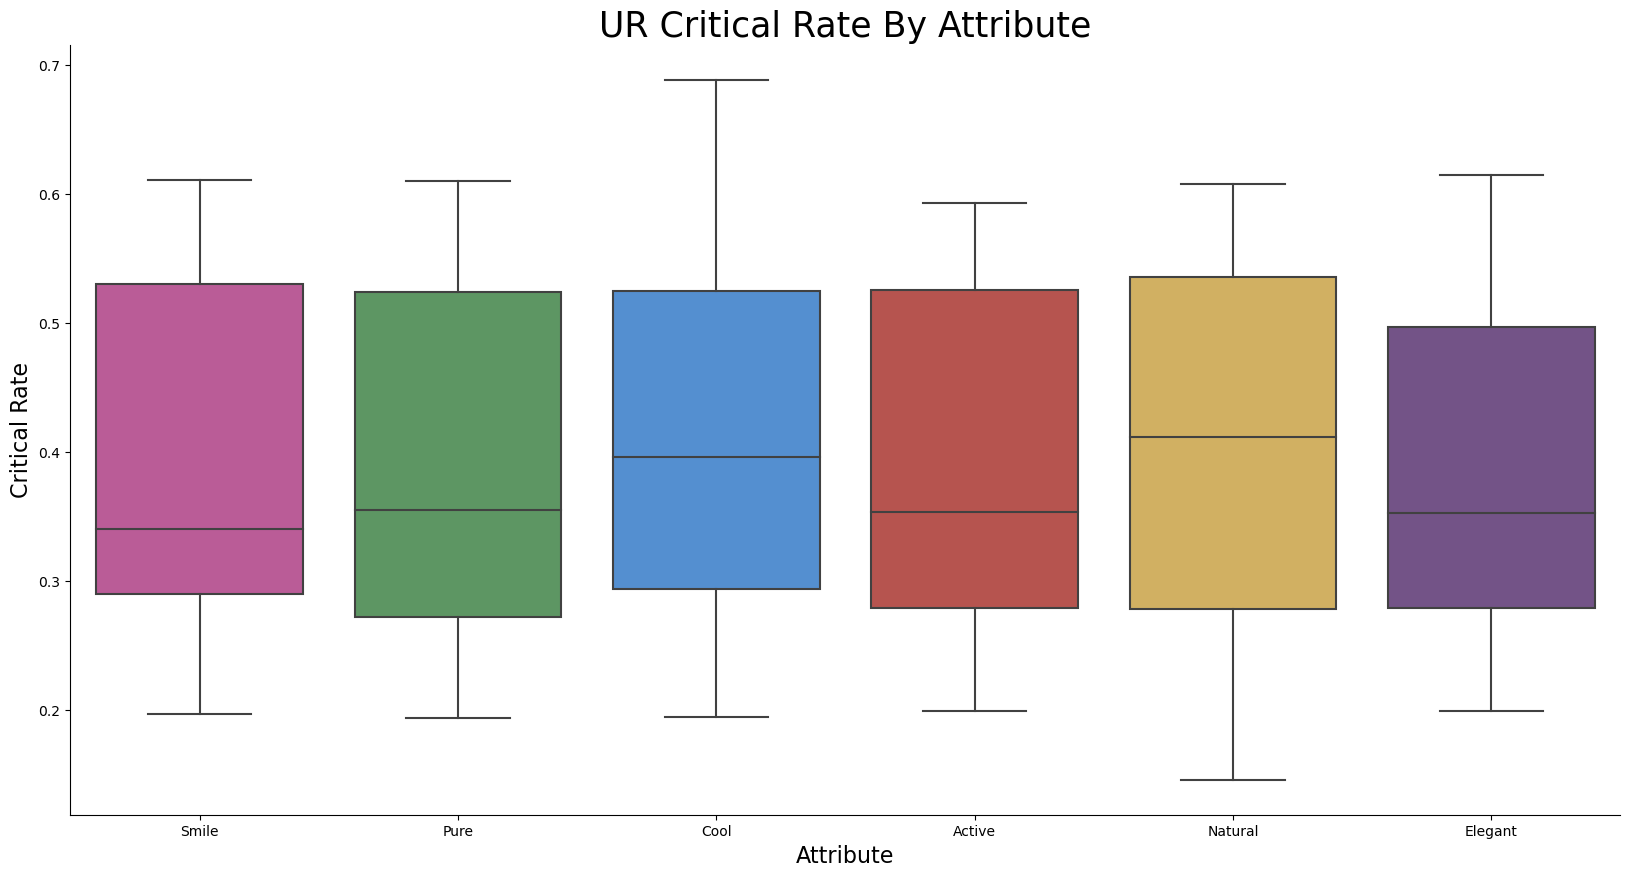

In [43]:
# What attribute of UR has the highest crit rate on average
plt.figure(figsize=(20, 10))

sns.boxplot(
    data = URCardData,
    x = "attribute",
    y = "max_critical_rate",
    order = attribute_order_list,
    palette = attribute_color_dict,
)

# The default ordering for seaborn's pastel palette ended up 
# being really cursed compared to the game's colors,
# so yknow what I'm keeping this here
#sns.boxplot(x=CardData["attribute"], y=CardData["max_critical_rate"], palette="pastel")

plt.xlabel("Attribute", fontsize=16)
plt.ylabel("Critical Rate", fontsize=16)
plt.title("UR Critical Rate By Attribute", fontsize=25)

sns.despine()
plt.show()

All things considered, these were tighter than I had initially expected. While I figured there wouldn't be a *heavy* bias towards any specific attribute, I didn't think it'd be quite so even. Checking it - there's only one cool card that's responsible for that high max crit rate - card number 482. and there's two cards which are responsible for the low min crit rate natural has - cards 151 and 463.

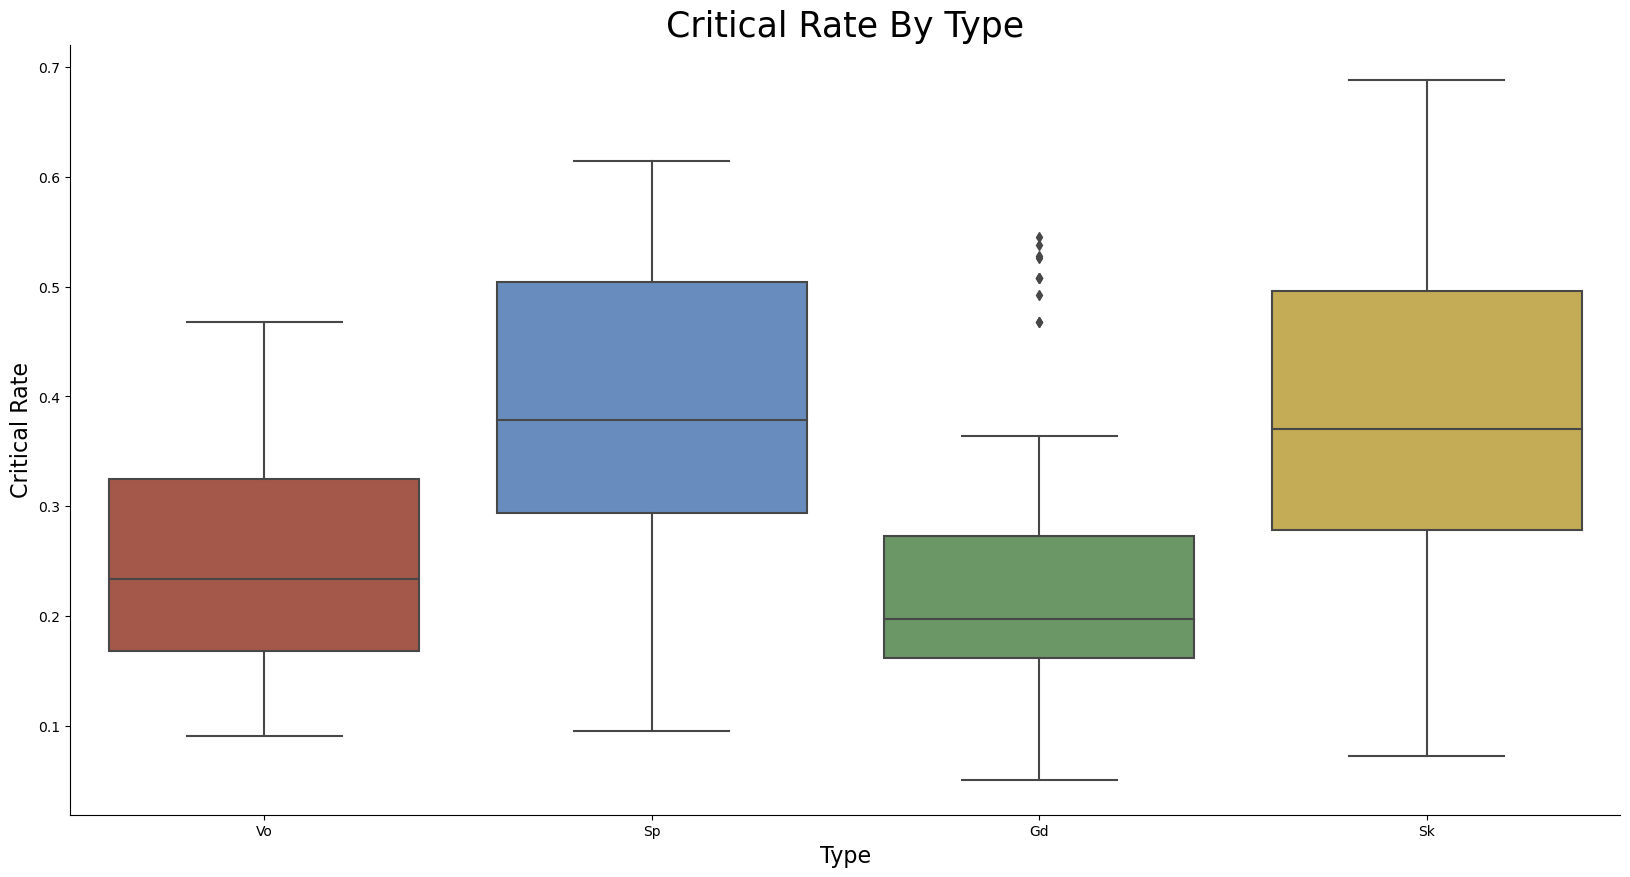

In [44]:
# What type has the highest crit rate on average
plt.figure(figsize=(20, 10))

sns.boxplot(
    data = CardData,
    x = "role",
    y = "max_critical_rate",
    order = role_order_list,
    palette = role_color_dict,
)

plt.xlabel("Type", fontsize=16)
plt.ylabel("Critical Rate", fontsize=16)
plt.title("Critical Rate By Type", fontsize=25)

sns.despine()
plt.show()

Another case where this was a relatively expected result. Vo types tend to have appeal as their highest stat, giving them most of their offensive power. Gd types generally do not have very high offensive stats in general. Sp types typically have a focus on gaining or modifying the sp gauge. Since the base voltage gained from an sp skill activation depends more heavily on technique than appeal, Sp types tend to have technique as their highest stat, generally speaking. Sk types are usually wildcards which is what explains the very broad range in crit rate.

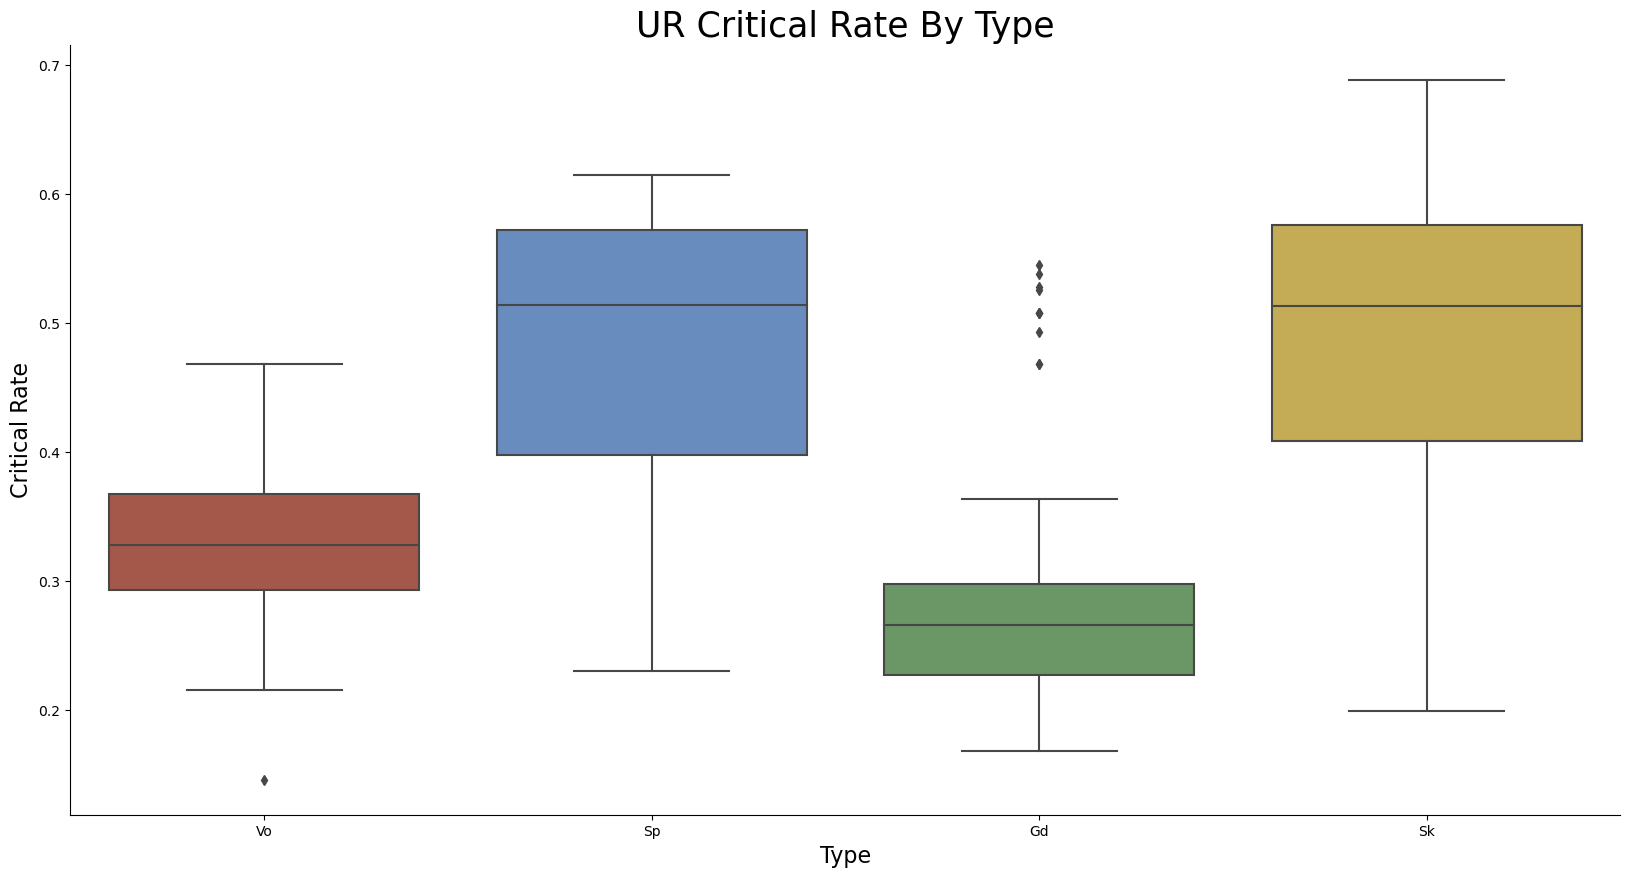

In [45]:
# What type of UR has the highest crit rate on average
plt.figure(figsize=(20, 10))

sns.boxplot(
    data = URCardData,
    x = "role",
    y = "max_critical_rate",
    order = role_order_list,
    palette = role_color_dict,
)

plt.xlabel("Type", fontsize=16)
plt.ylabel("Critical Rate", fontsize=16)
plt.title("UR Critical Rate By Type", fontsize=25)

sns.despine()
plt.show()

This is essentially the same graphic as above, we're just only looking at UR cards now. The conclusions are basically the same, but we end up with even tighter more exagerated versions of the conclusions that were drawn before. Frankly removing the Rs and SRs made a larger change than expected though.

In [46]:
#TODO: Look into maybe combining the above 3 plots into 1?

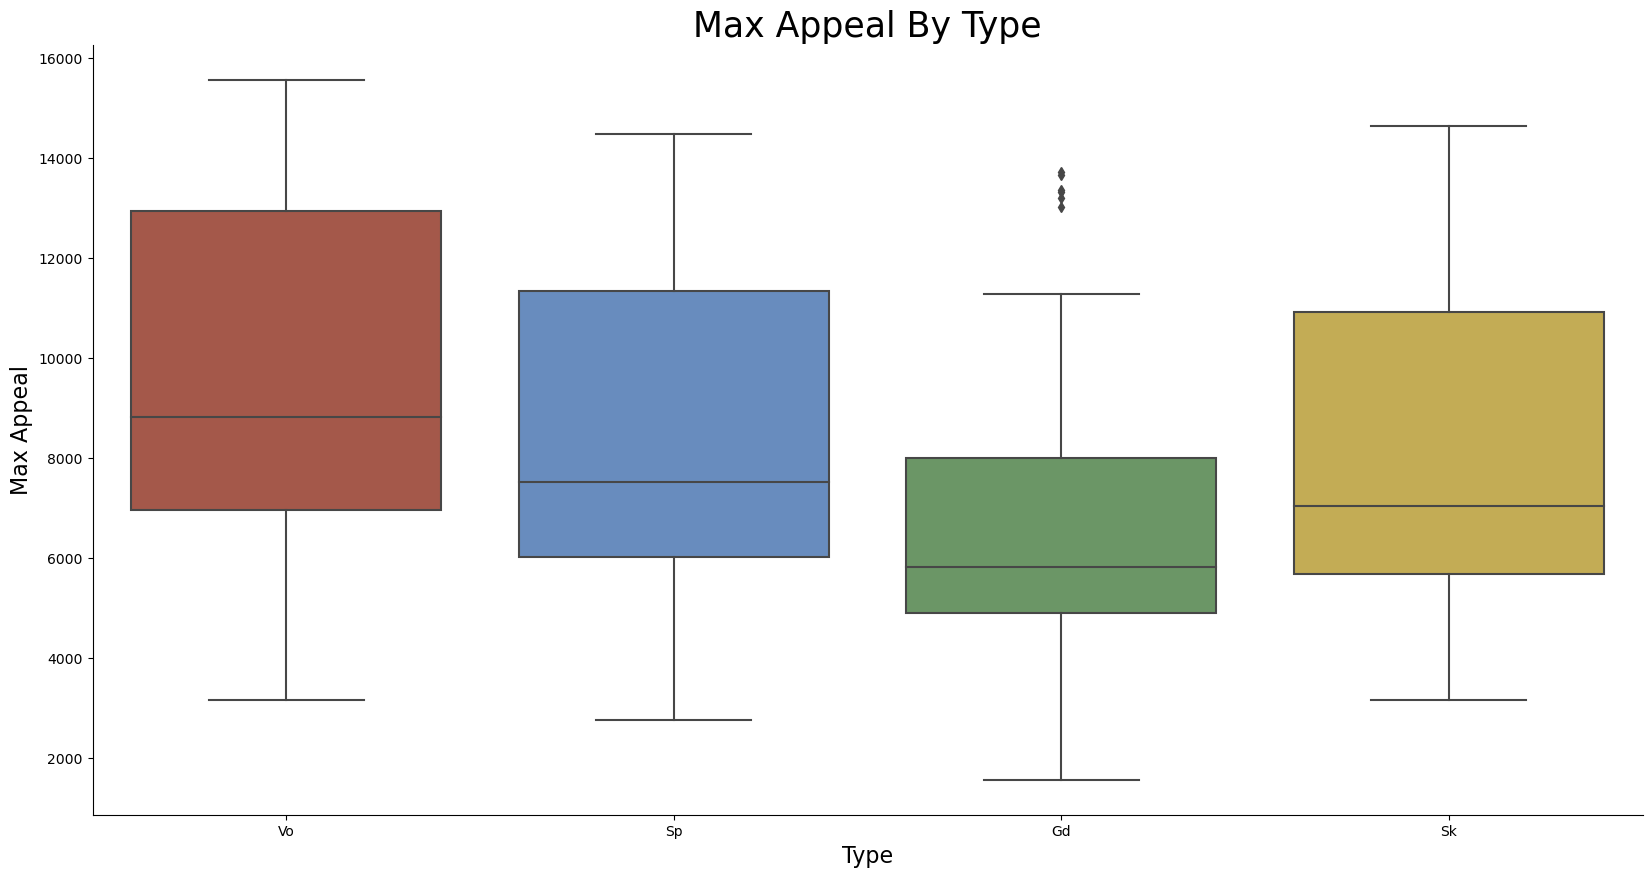

In [47]:
# What card type has the highest appeal on average
plt.figure(figsize=(20, 10))

sns.boxplot(
    data = CardData,
    x = "role",
    y = "total_max_appeal",
    order = role_order_list,
    palette = role_color_dict,
)

plt.xlabel("Type", fontsize=16)
plt.ylabel("Max Appeal", fontsize=16)
plt.title("Max Appeal By Type", fontsize=25)

sns.despine()
plt.show()

While not being the same variables as the above few plots, it can be considered somewhat of a companion to them as it further demonstrates the conclusions draw. Vo types tend to have low crit rates since they have high appeal values and Gd types just aren't meant to be offensive powerhouses. Sk types are weird. What new can be seen here though is Sp types, while they usually have lower appeal stats, they typically make up for it with their higher crit rates. Many people often prefer to run Sp types over Vo types when they have the choice. While absolutely not the sole reason for it, this crit rate/appeal relationship is certainly a part of it.

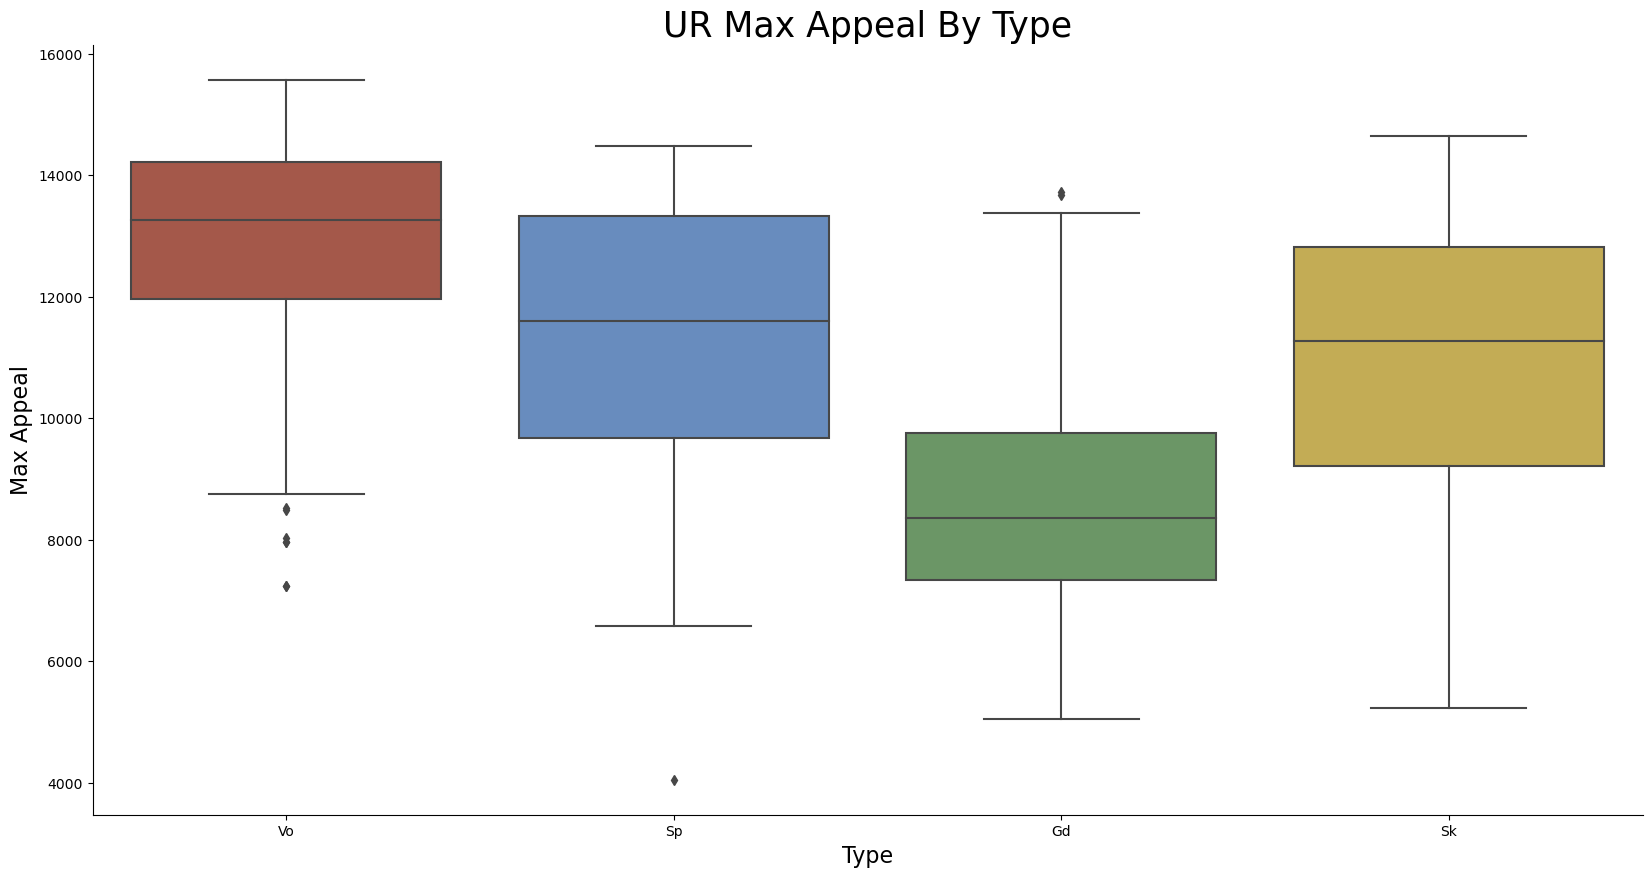

In [48]:
# What card type of UR has the highest appeal on average
plt.figure(figsize=(20, 10))

sns.boxplot(
    data = URCardData,
    x = "role",
    y = "total_max_appeal",
    order = role_order_list,
    palette = role_color_dict,
)

plt.xlabel("Type", fontsize=16)
plt.ylabel("Max Appeal", fontsize=16)
plt.title("UR Max Appeal By Type", fontsize=25)

sns.despine()
plt.show()

This is, again, essentially the same chart as above, but since we're filtering for UR cards we get more exagerated values.

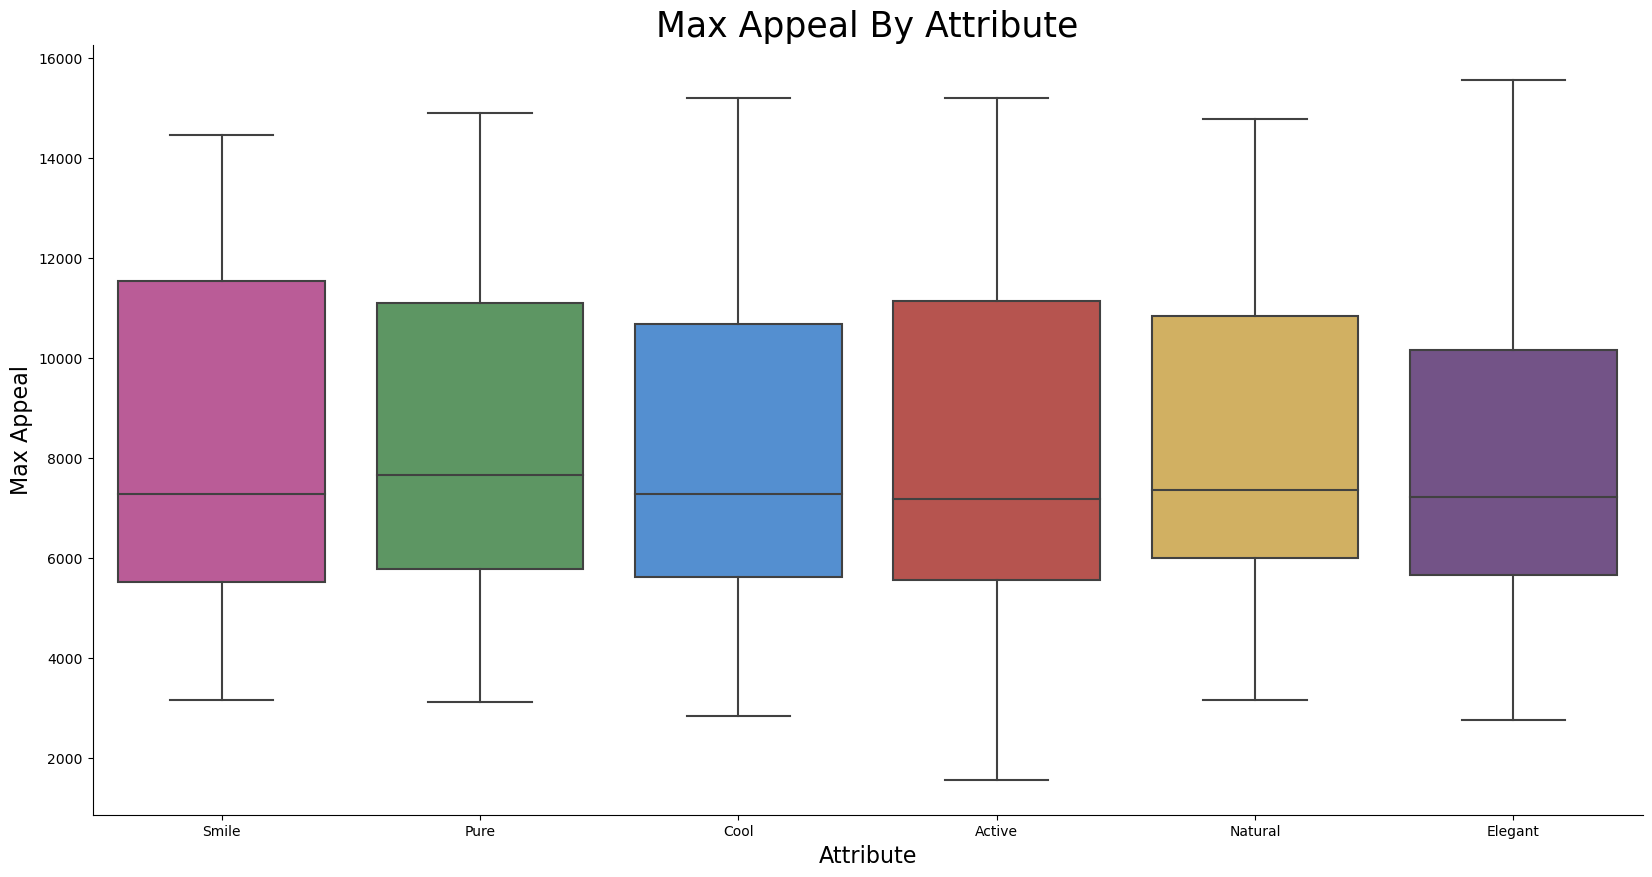

In [49]:
# What attribute has highest appeal on average
plt.figure(figsize=(20, 10))

sns.boxplot(
    data = CardData,
    x = "attribute",
    y = "total_max_appeal",
    order = attribute_order_list,
    palette = attribute_color_dict,
)

plt.xlabel("Attribute", fontsize=16)
plt.ylabel("Max Appeal", fontsize=16)
plt.title("Max Appeal By Attribute", fontsize=25)

sns.despine()
plt.show()

Similar to the first chart, the main surprise here is just quite how evenly distributed appeal values tend to be across various attribute cards. This one does appear to have more variance than the crit rate chart though. The only reason that active has such a low minimum is, once again, a single card - in this case card 205.

In [50]:
# I asked for any requests for some things people might like to see from this in discord
# got the following as a response which somewhat inspired the following chart:
#
# another thing i think might be interesting is some measure of stat inflation. 
# probably something like splitting the cards into classes (along the lines of 'fes UR Vo') 
# and see how each card compares to previous cards in that class

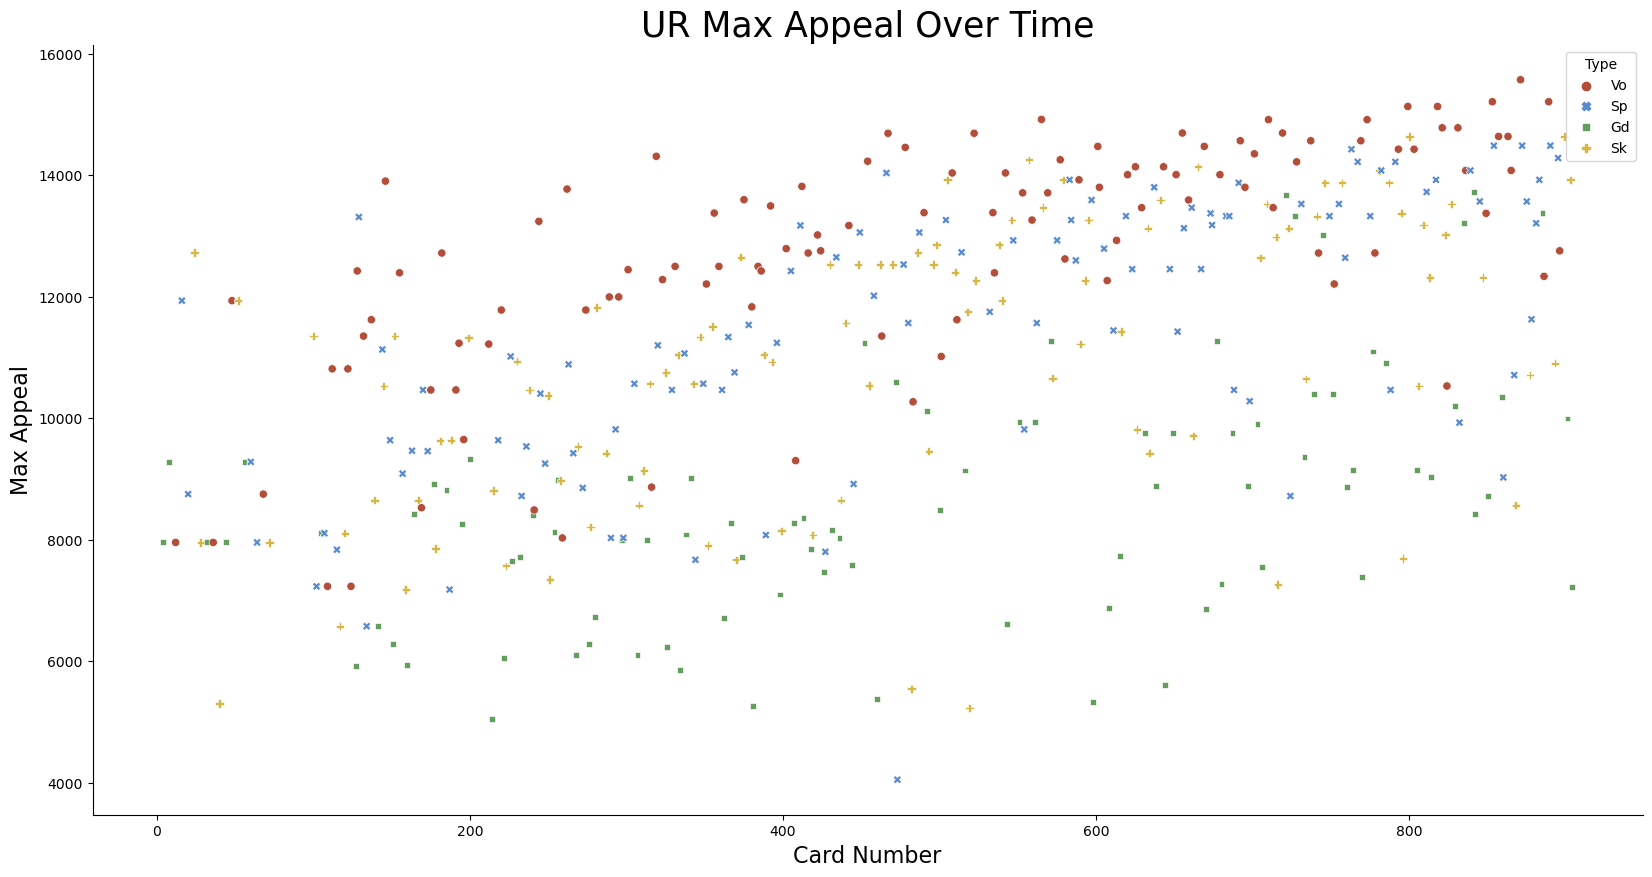

In [51]:
# UR Max Appeal Over Time, by Type

plt.figure(figsize=(20, 10))

sns.scatterplot(
    data = URCardData,
    x = "ordinal",
    y = "total_max_appeal",
    hue = "role",
    style = "role",
    palette = role_color_dict,
    hue_order = role_order_list,
    style_order = role_order_list,
)

plt.legend(title="Type")

plt.xlabel("Card Number", fontsize=16)
plt.ylabel("Max Appeal", fontsize=16)
plt.title("UR Max Appeal Over Time", fontsize=25)

sns.despine()
plt.show()

Similar to some of what we've seen already (high appeal Vo cards, low appeal Gd, etc), but hey now you can see how appeal changes over time, broken down by type.

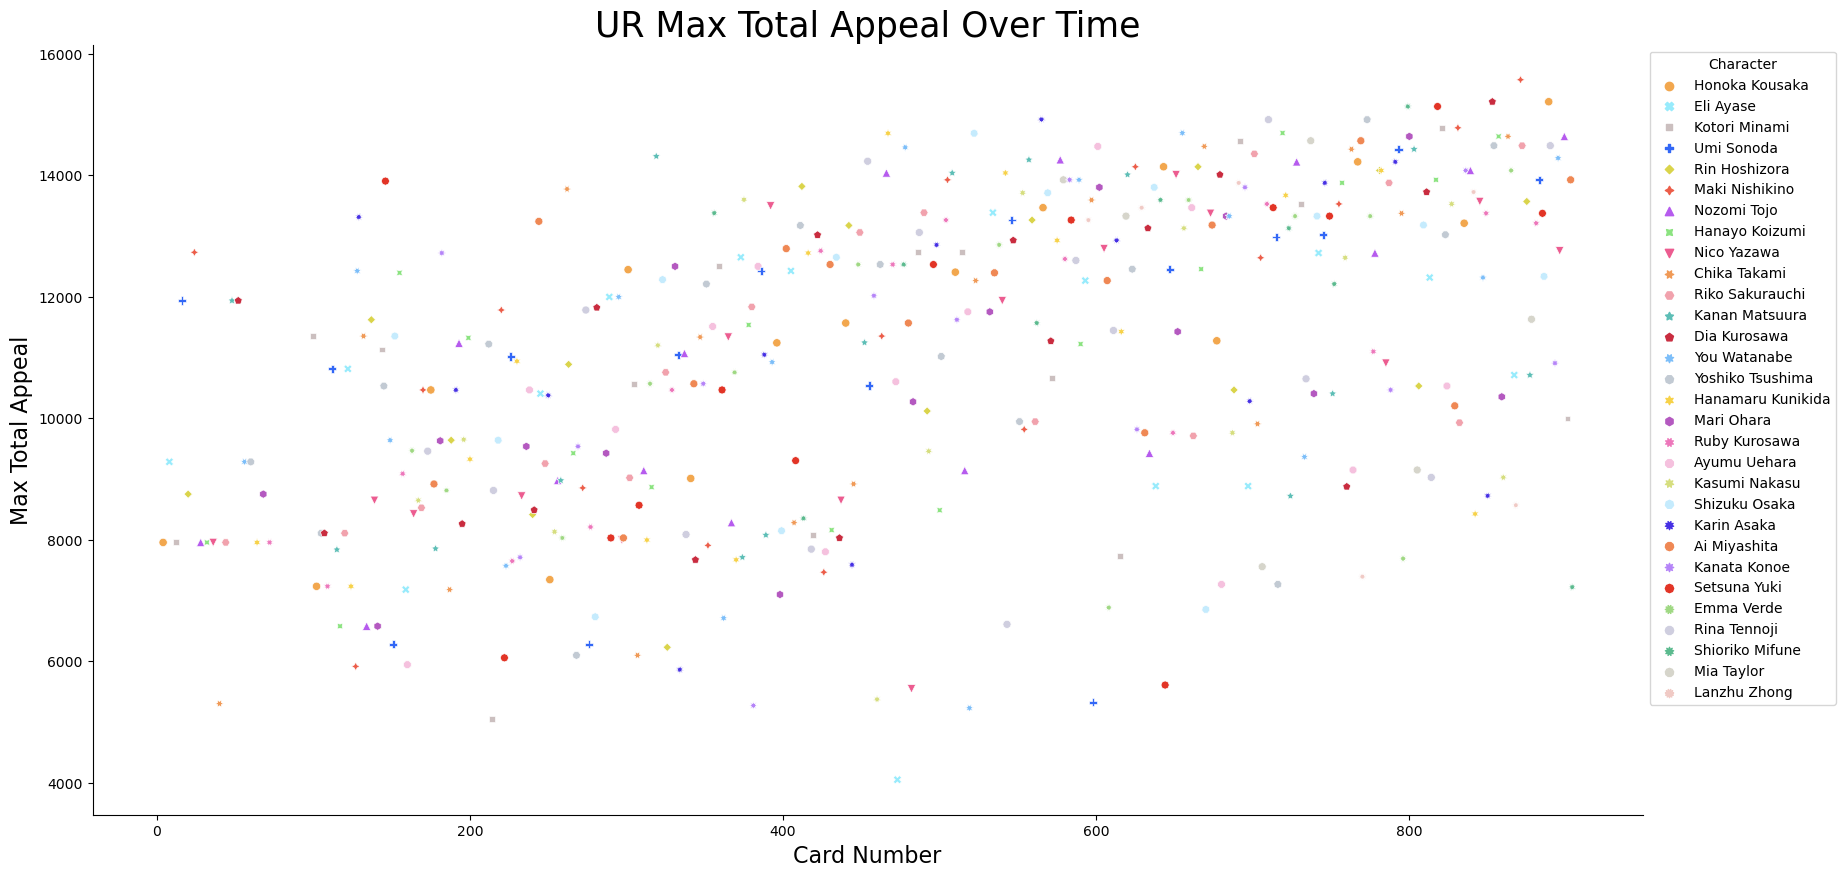

In [52]:
# UR Max Total Appeal Over Time, by Character

# I mostly just made this one to see how that many items in the hue would look

plt.figure(figsize=(20, 10))

sns.scatterplot(
    data = URCardData,
    x = "ordinal",
    y = "total_max_appeal",
    hue = "member",
    style = "member",
    palette = member_color_dict,
    hue_order = member_order_list,
    style_order = member_order_list,
)

plt.legend(title="Character", bbox_to_anchor=(1, 1))

plt.xlabel("Card Number", fontsize=16)
plt.ylabel("Max Total Appeal", fontsize=16)
plt.title("UR Max Total Appeal Over Time", fontsize=25)

sns.despine()
plt.show()

Well this one would probably make a better *interactive* graphic than a static one like this. I mostly just made this as I was curious how it would look to have this many items in the legend. There's not too too many conclusions that can be drawn as this is pretty messy all things considered, but at least it looks pretty.

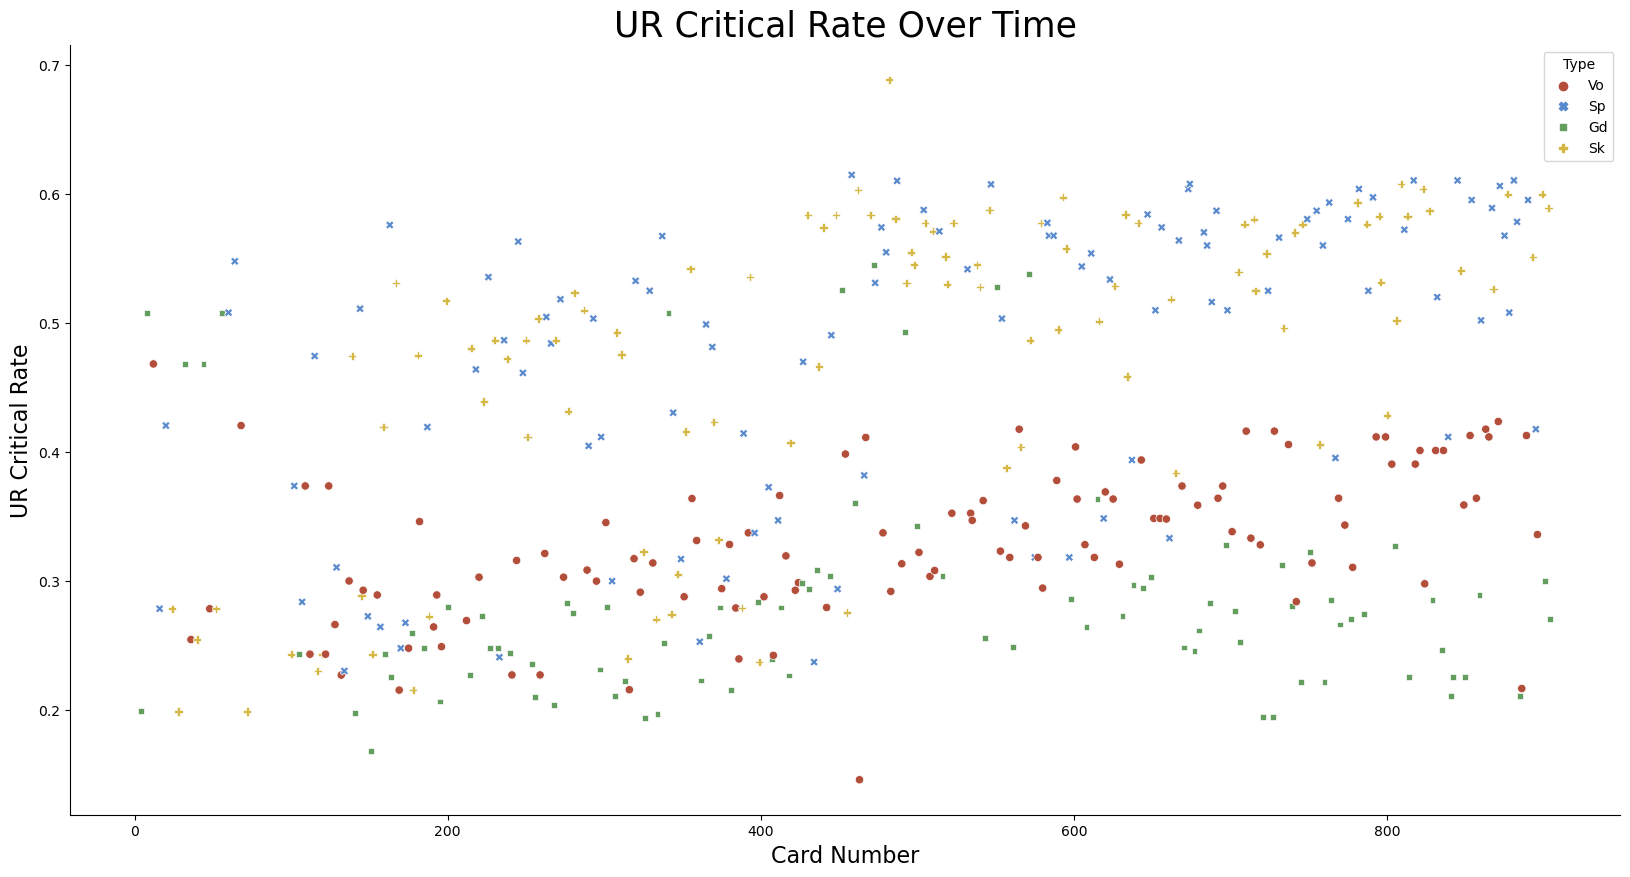

In [53]:
# Ur Max Crit Rate Over Time, by Type

plt.figure(figsize=(20, 10))

sns.scatterplot(
    data = URCardData,
    x = "ordinal",
    y = "max_critical_rate",
    hue = "role",
    style = "role",
    palette = role_color_dict,
    hue_order = role_order_list,
    style_order = role_order_list,
)

plt.legend(title="Type")

# version if you want all cards, with hue corresponding to rarity
#sns.scatterplot(CardData, x="ordinal", y="max_critical_rate", hue="rarity", palette="flare", markers=True)

plt.xlabel("Card Number", fontsize=16)
plt.ylabel("UR Critical Rate", fontsize=16)
plt.title("UR Critical Rate Over Time", fontsize=25)

sns.despine()
plt.show()

This is again, similar to some of the other plots we've seen, but here it's really evident that there's striation in crit rates.

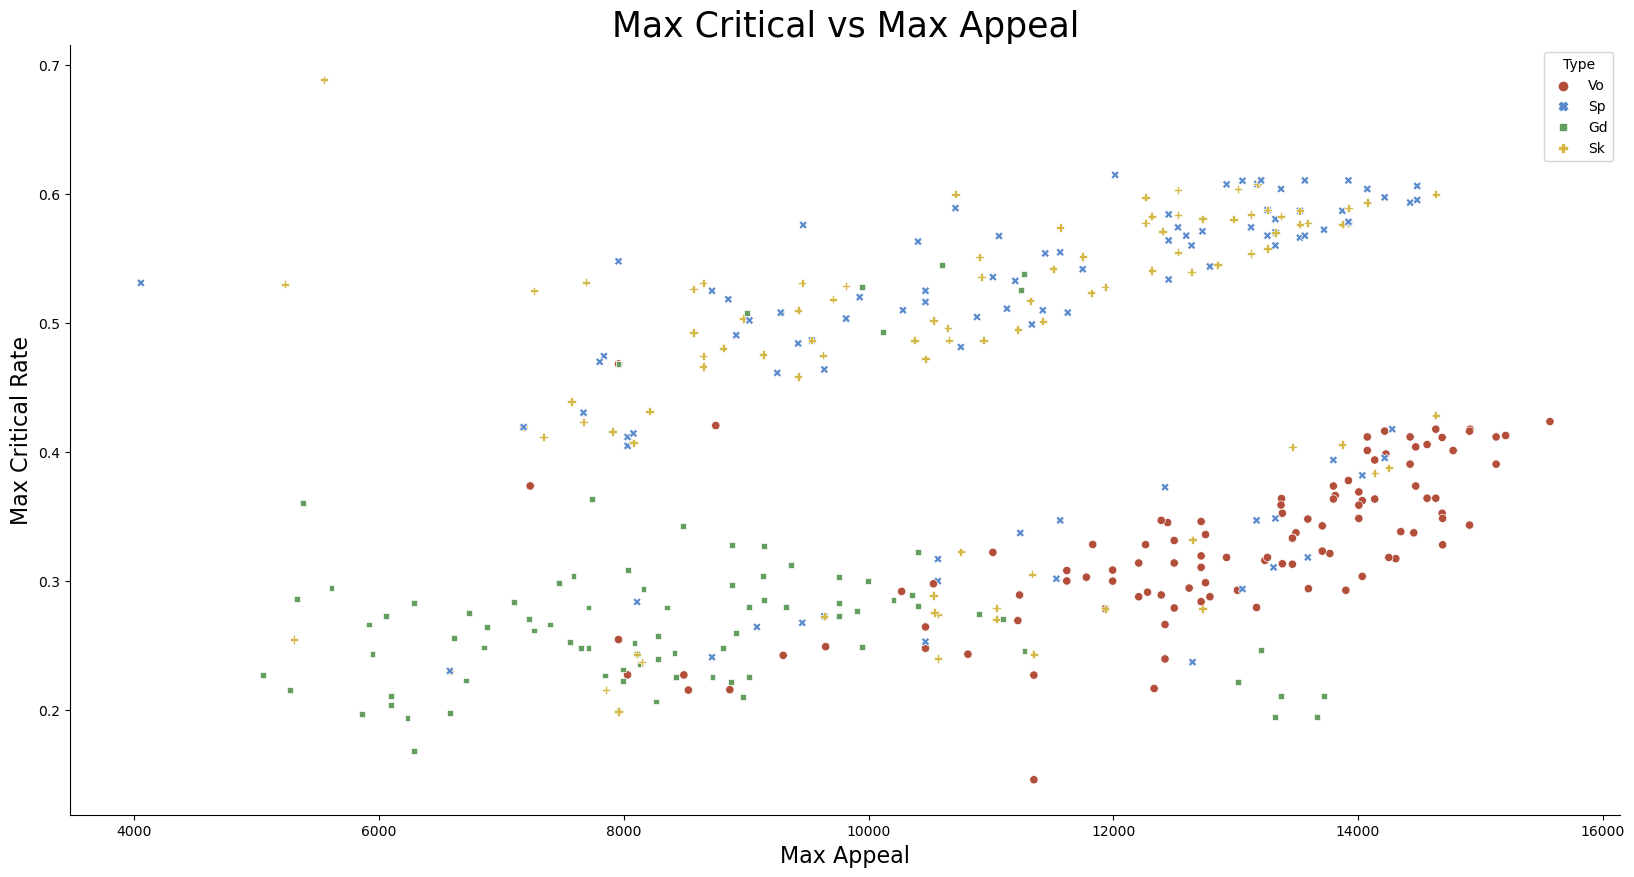

In [54]:
# Max Crit Rate vs Max Appeal

plt.figure(figsize=(20, 10))

sns.scatterplot(
    data = URCardData,
    x = "total_max_appeal",
    y = "max_critical_rate",
    hue = "role",
    style = "role",
    palette = role_color_dict,
    hue_order = role_order_list,
    style_order = role_order_list,
)

plt.legend(title="Type")

plt.xlabel("Max Appeal", fontsize=16)
plt.ylabel("Max Critical Rate", fontsize=16)
plt.title("Max Critical vs Max Appeal", fontsize=25)

sns.despine()
plt.show()

Alright, well this one isn't something we've really seen before *and* there's some interesting stuff to see here. The first thing that can probably be noted is the jarring, frankly very linear, gap that's missing any data points towards the middle/center to upper right portion of the graph. This is very likely due to the 'critical sense' attribute some cards have, where if their technique is their highest base stat, they gain 15% critical rate, which would explain the sharp edges of it. A few other trends that can be noted: 1) Gd types are mostly clustered towards the bottom left portion of the graph - which is to be expected when looking at offensive stats of defensive cards, 2) A significant portion of the Vo types are clustered towards the bottom right, which should be somewhat evident for reasons already discussed, 3) There's only 3 cards with the unusual stat layout where they have very high crit rate, but very low appeal - these turned out to be cards 473, 482, and 796, 4) there does definitely appear to be a trend wherein the higher the appeal stat a card has, the higher its crit rate tends to be (probably just due to inflating of stats and/or offensive stat tradeoff from defensive).

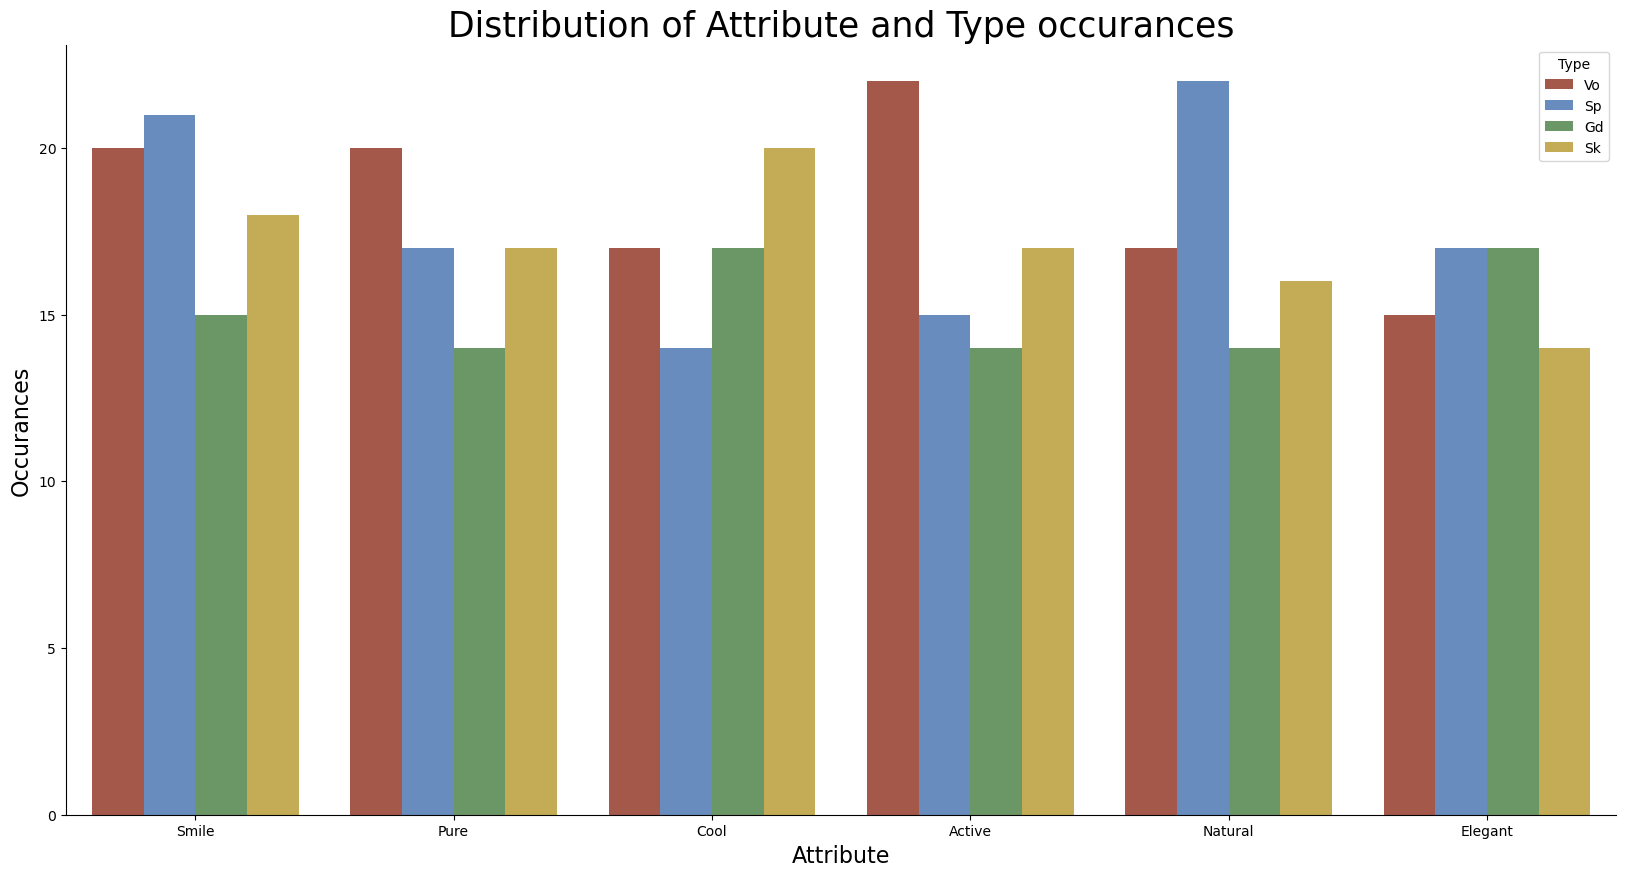

In [55]:
# Type vs Attribute

plt.figure(figsize=(20, 10))

sns.countplot(
    data = URCardData,
    x = "attribute",
    hue = "role",
    order = attribute_order_list,
    palette = role_color_dict,
    hue_order = role_order_list,
)

plt.legend(title="Type")

plt.xlabel("Attribute", fontsize=16)
plt.ylabel("Occurances", fontsize=16)
plt.title("Distribution of Attribute and Type occurances", fontsize=25)

sns.despine()
plt.show()

I believe this graphic mostly speaks for itself. It is also essentially a combination of 2 cells from the [Some Purely Numeric Analysis](#Some-Purely-Numeric-Analysis:) section above.

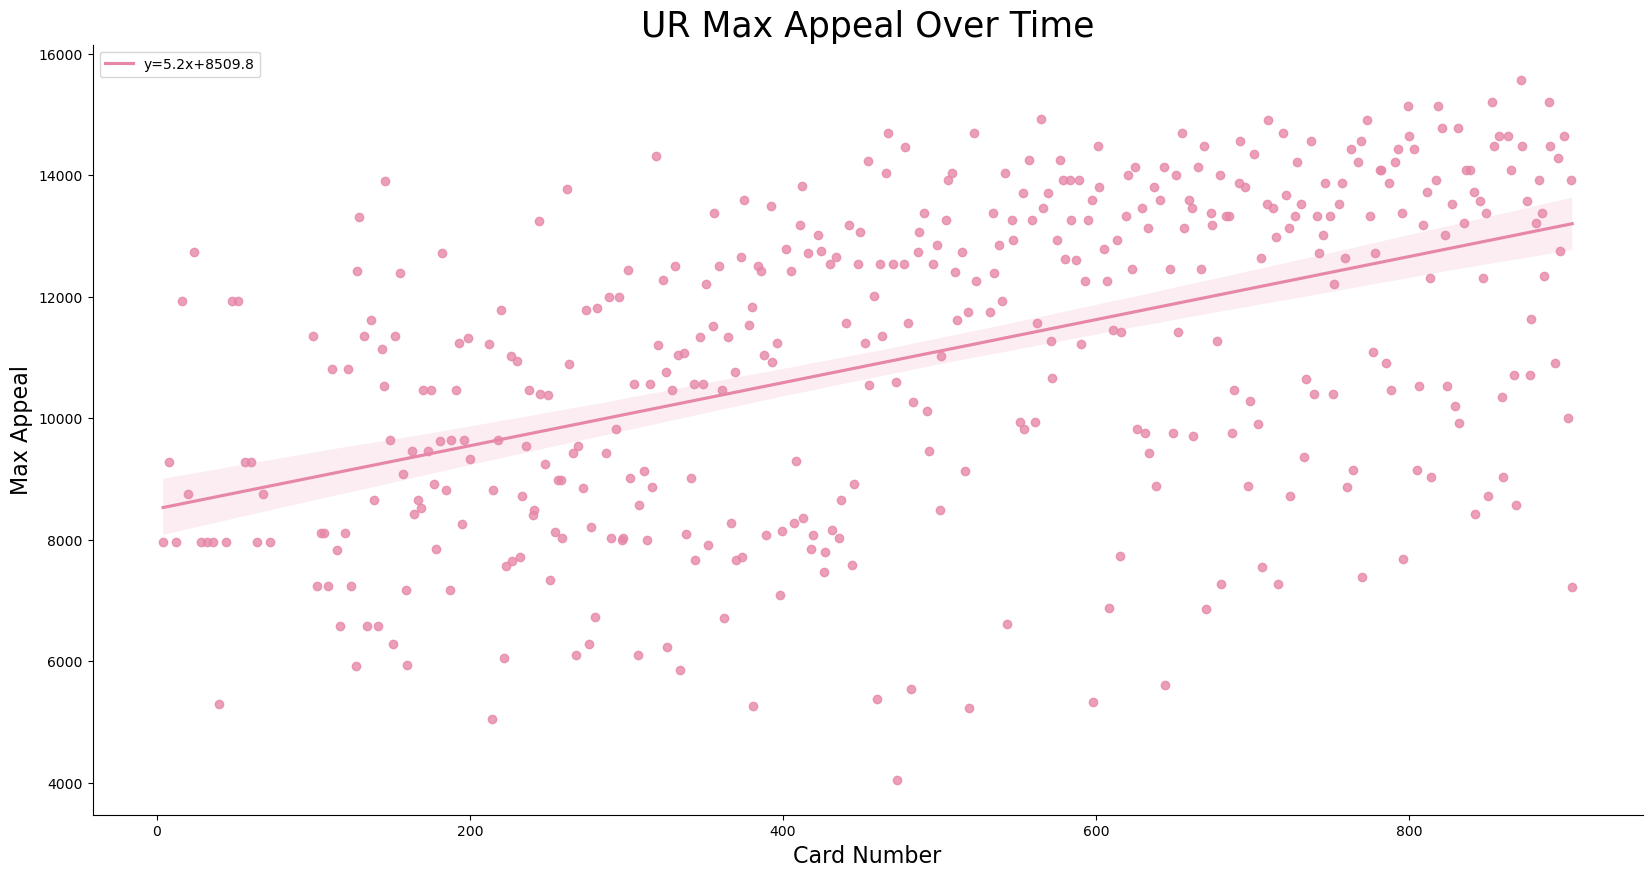

In [56]:
# UR Max Appeal Over Time with line of best fit

plt.figure(figsize=(20, 10))

slope, intercept, r_value, p_value, std_err = stats.linregress(URCardData["ordinal"],URCardData["total_max_appeal"])

sns.regplot(
    URCardData,
    x = "ordinal",
    y = "total_max_appeal",
    line_kws = {'label':"y={0:.1f}x+{1:.1f}".format(slope, intercept)},
    color = stat_color_dict["Appeal"],
)

plt.legend(loc = "upper left")

plt.xlabel("Card Number", fontsize=16)
plt.ylabel("Max Appeal", fontsize=16)
plt.title("UR Max Appeal Over Time", fontsize=25)

sns.despine()
plt.show()

Alright, well [it's time for the moment you've been waiting for](https://youtu.be/q5th225wgsk) here it is, the power creep. Yup, those stats were definitely increasing a decent bit over time. Comparing this to the analysis I did back ~2 years ago or something (looks like card 243 was the most recent at the time) - the previous line of best fit had the equation $5.62x + 2956$ with an $R^2$ value of $0.081$. While the slope has stayed pretty similar, holy cow the y-intercept has gone up dramatically.

<Figure size 2000x1000 with 0 Axes>

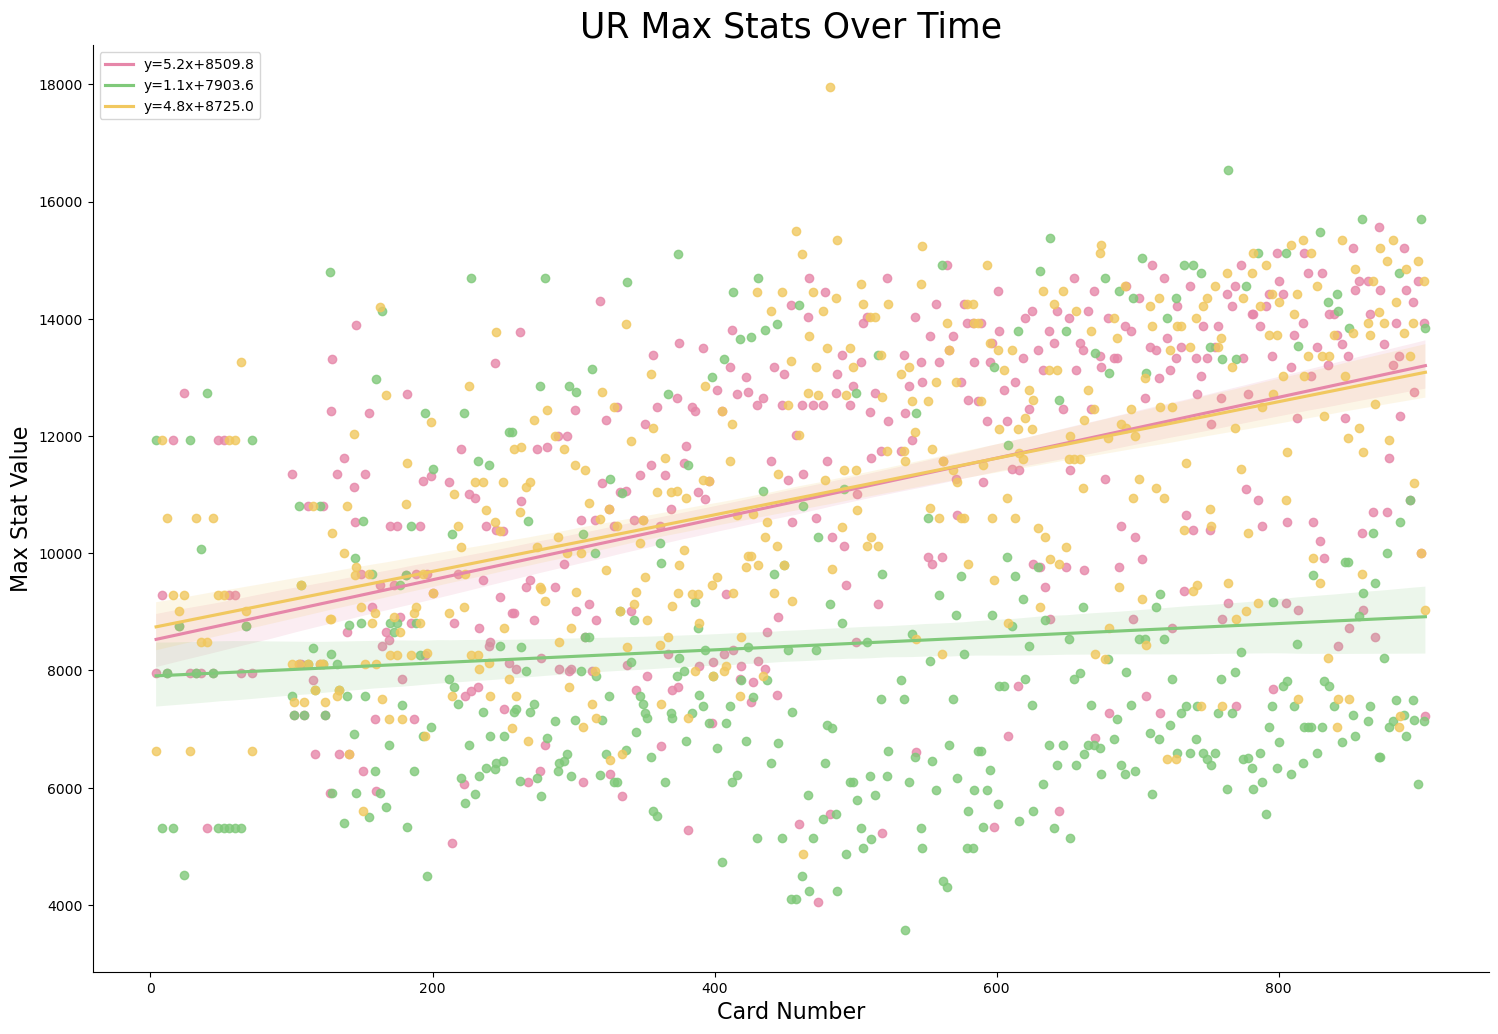

In [57]:
# UR Max Appeal Over Time, by Type

plt.figure(figsize=(20, 10))

appeal_slope, appeal_intercept, appeal_r_value, appeal_p_value, appeal_std_err = stats.linregress(URCardData["ordinal"],URCardData["total_max_appeal"])
stamina_slope, stamina_intercept, stamina_r_value, stamina_p_value, stamina_std_err = stats.linregress(URCardData["ordinal"],URCardData["total_max_stamina"])
technique_slope, technique_intercept, technique_r_value, technique_p_value, technique_std_err = stats.linregress(URCardData["ordinal"],URCardData["total_max_technique"])

stat_grid = sns.FacetGrid(
    data = URCardData,
    height=10,
    aspect=1.5,
);
stat_grid.map(
    sns.regplot,
    "ordinal",
    "total_max_appeal",
    line_kws = {'label':"y={0:.1f}x+{1:.1f}".format(appeal_slope, appeal_intercept)},
    color = stat_color_dict["Appeal"],
)
stat_grid.map(
    sns.regplot,
    "ordinal",
    "total_max_stamina",
    line_kws = {'label':"y={0:.1f}x+{1:.1f}".format(stamina_slope, stamina_intercept)},
    color = stat_color_dict["Stamina"],
)
stat_grid.map(
    sns.regplot,
    "ordinal",
    "total_max_technique",
    line_kws = {'label':"y={0:.1f}x+{1:.1f}".format(technique_slope, technique_intercept)},
    color = stat_color_dict["Technique"],
)

# Legend currently does not display the label for which color is which data
plt.legend(loc = "upper left")

plt.xlabel("Card Number", fontsize=16)
plt.ylabel("Max Stat Value", fontsize=16)
plt.title("UR Max Stats Over Time", fontsize=25)

sns.despine()
plt.show()

More or less just an extention of the last graphic - here's the power creep but in <span style="color:#80c97a"> green </span> and <span style="color:#f1c85f"> yellow </span> flavors as well!

So while we can also say that technique has increased at a very similar rate to appeal, holy cow has stamina not kept up. This is probably because cards have tended to want higher offensive stats, as that makes them more desirable, and they've likely "traded off" stamina for *even higher* offensive stats.

In [58]:
# TODO: Add some sort of way to distinguish stat by more than just color
# TODO: Add some sort of legend to label the colors too
# TODO: Maybe check out stamina on just Gd types
# TODO: Maybe look at changes in sum of all stats?

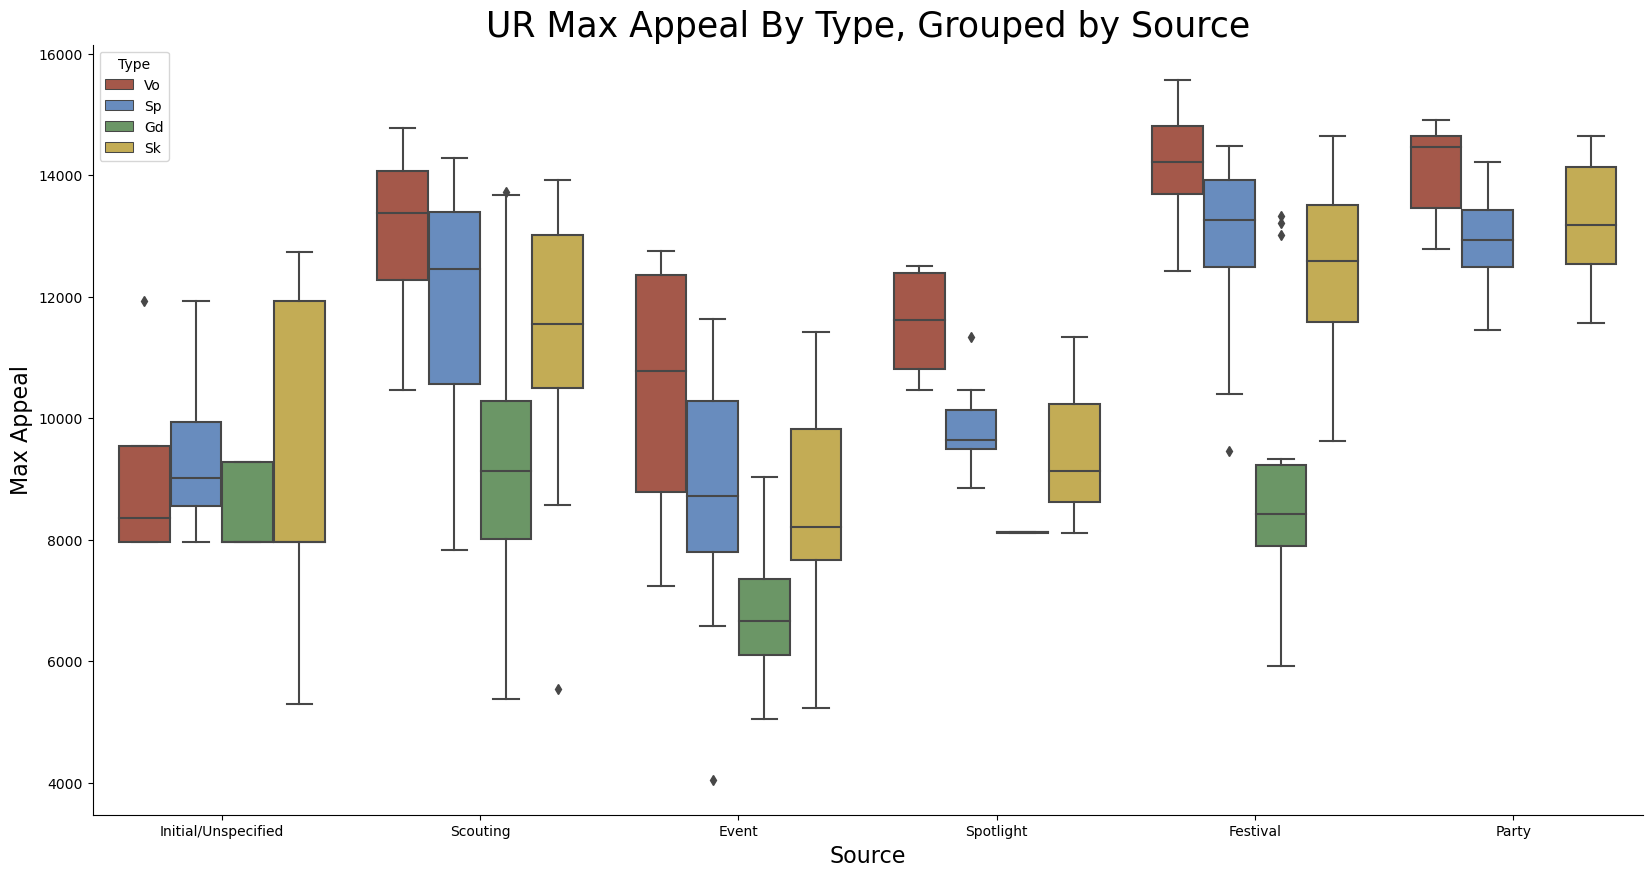

In [59]:
# Max appeal by type for release URs and other URs

plt.figure(figsize=(20, 10))

#df1 = URReleaseCardData[""]

sns.boxplot(
    data = URCardData,
    x = "source",
    y = "total_max_appeal",
    hue = "role",
    hue_order = role_order_list,
    palette = role_color_dict,
)

plt.legend(title="Type")

plt.xlabel("Source", fontsize=16)
plt.ylabel("Max Appeal", fontsize=16)
plt.title("UR Max Appeal By Type, Grouped by Source", fontsize=25)

sns.despine()
plt.show()

Lastly let's look at some how appeal is related to card type and source. As is pretty clear, Party and Festival cards very clearly have inflated appeal stats compared to all their more common counterparts. Interestingly there isn't even a *single* Gd type Party card.

In [60]:
# TODO: Maybe organize graphics a bit and make subcategories grouping them.

## **Overview & Conclusion:**

Well SIFAS has had a ride, I don't know if good, but it certainly had *one*. It's certainly not been exactly smooth between speedups on the worldwide server to catch up to the Japanese server, being sold off to a different development company, a dwindling playerbase, and a never changing, often tedious, event schedule, but yknow what I'm going to miss it. The vast majority of players never bothered understanding many of the details discussed in this notebook (the added crit rate bonus for example), and with constantly increasing song difficulty, many people just considered playing the game not worth their time. And I can't really blame them. Powercreep tends to be an inevitability in games like this, and keeping up with the meta just really isn't what most players get/got the game for. 

Being able to play fully animated real time rendered music videos with easily swapable costumes *that runs on a smartphone* is ***really cool***, but if you can't clear the song - yknow the core gameplay - it can be really offputting. The game was confusing to many people who came from the earlier Love Live! game - School Idol Festival, which also ended its service earlier this year on March 31, 2023, which was a pure rhythm game that didn't have nearly as complex mechanics. Can you tap the notes in time? Great then you can clear the song. This is in stark contrast to something like Ketsui no Hikari's ~160,000 stamina damage even if you clear the song flawlessly. (For reference look at how much stamina each card tends to have above.) Ketsui no Hikari isn't even the worst offender of this type of thing. The point stands though - even if you take the time to read the paragraphs of ***stuff*** that ***every individual*** song just ***does*** you just might not be able to with your current cards in their current upgrade state.

While many of these graphs show that, yeah a lot of the cards look decent, to downright good in some cases, on paper when you just look at the statline, that's only one part of the big picture. Many players don't even pull for the stats and instead just pull for their favorite character, and/or purely for the costumes those cards unlock. There comes a time when every live service game is going to reach its end of service. While lifespans vary by monetization scheme, brand loyalty, etc, it's still sad to see one go, even if it's gameplay left a lot to be desired.

So SIFAS, I'm gonna miss ya. You were very nice to look at and technologically pretty cool. And even if you didn't have the greatest gameplay, you were still a lot of fun for someone like me.